In [1]:
#Some packages needs to be installed in order to run this code
#Moving Pandas is the most complicated to install
#Get anaconda - create new environment


import numpy as np
import json

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data

#import requests
import geojson
from pyproj import CRS
#from owslib.wms import WebMapService
#from owslib.wcs import WebCoverageService

import scipy.stats as stats
from scipy.signal import lfilter

import random

#Packages for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Packages for interpreting elevation data
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

#MovingPandas (Kalman-filter)
import movingpandas as mpd

import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp

from datetime import datetime, timedelta
from holoviews import opts, dim

import time

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import pickle

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp

# Welcome to my notebook
Here we will process bicycle-data (GPS) and try to do some statistics to it.

In [2]:
#Read data into panda
df = pd.read_json(r"trip5000.json")

## Reading the data
The "issue" with geo-data is that it is in a specific format. All geodata-files contain one column with the "geography" of the dataframe. For example it could be:
* Point(1 2) - one coordinate per row
* LineString ((1 2),(2 2),(3 1)) - multiple coordinates in a line
* etc..

GeoPandas handles this type of data really well, but I've realized that when this type of data gets converted to json/csv for saving, there are some issues which can be handled in different ways.

Here we are reading from a json-file and in order to write geodata to json the geodata has to be converted to a "feature", which is why we are reading it like this: first as a dataframe, and then from_features we read it as a geodataframe. Then GeoPandas knows what it's dealing with. 

We will also read from some other formats later, and will go through those when we get to them.

## csr
crs is the coordinate reference system. We want to use the same crs as the original data was projected onto, and this data was projected onto epsg:4617. This is a "degree" based coordinate-system and we will use it throughout (with some minor exeptions)

In [3]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:4617') 

<Axes: >

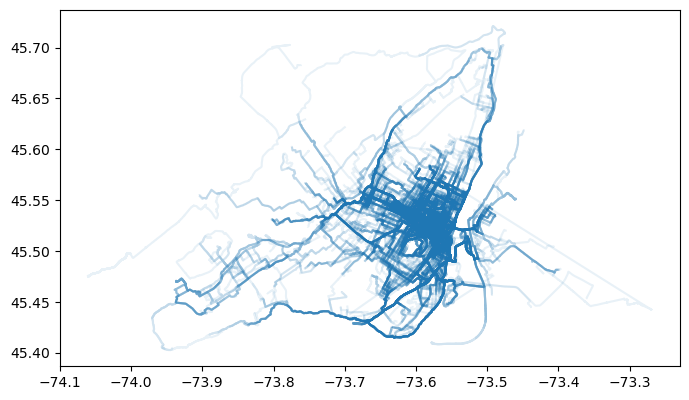

In [1317]:
gdf.plot(alpha=0.1,figsize=(8, 8))

In [4]:
gdf.head(3)

geometry                 stop  \
0  LINESTRING (-73.57748 45.50690, -73.57751 45.5...  2013-06-25 16:34:16   
1  LINESTRING (-73.62897 45.46372, -73.62891 45.4...  2013-07-25 14:40:06   
2  LINESTRING (-73.58481 45.56786, -73.58153 45.5...  2013-07-25 14:43:12   

   id_origine                start  length  purpose  \
0          52  2013-06-25 16:21:21    3163  Commute   
1        2325  2013-07-25 14:37:42    1066  Courses   
2        2326  2013-07-25 14:19:15    5619  Courses   

                                liste_segments_jsonb  n_coord    id  
0  [{'source': 'GEOBASE', 'id': 1260962}, {'sourc...      511    52  
1  [{'source': 'GEOBASE', 'id': 1310311}, {'sourc...      196  2325  
2  [{'source': 'GEOBASE', 'id': 1170061}, {'sourc...     1036  2326

## Initial process
The data we have is one row per trip. With the coordinates being in the LineString-form mentioned above.
Below we:
* let the computer know that our date/time-data is actually datetime-data
* Calculate the duration of each trip (in seconds) and add that column to the dataframe
* Split each LineString  into a MultiLineString of individual segments: [(a, b, c)] -> [(c,a), (a,b), (b,c)]
* Explode that MultiLineString: 

               1 [(a, b, c)] [data1]  -> [(c,a), (a,b), (b,c)] [data1]
               2 [(d, e, f)] [data2]  -> [(f,d), (d,e), (e,f)] [data2]
               --->
               1 1 [(c,a)]  [data1]
               1 2 [(a,b)]  [data1]
               1 3 [(b,c)]  [data1]
               2 1 [(f,d)]  [data2]
               2 2 [(d,e)]  [data2]
               2 3 [(e,f)]  [data2]

In [5]:
gdf["start"] = gdf['start'].apply(pd.to_datetime)
gdf["stop"] = gdf['stop'].apply(pd.to_datetime)
gdf["duration"] = (gdf['stop'] - gdf['start']) / pd.Timedelta(seconds=1)

In [6]:
#Here we split each linestring into a multilinestring of individual segments [a, b, c] -> [(c,a), (a,b), (b,c)]
#this also means that the first element needs to be deleted
#It takes like 10 minutes but it is by far the fasted method i've found
gdf["geo"] = gdf.apply(lambda x: MultiLineString([LineString([x['geometry'].coords[i-1], x['geometry'].coords[i]]) for i in range(len(x['geometry'].coords))]),axis=1)


#Make that into the geometry
gdf.set_geometry("geo", drop=False, inplace=True, crs='epsg:4617')
#And explode it based on geo
gdf = gdf.explode(index_parts=True)
gdf.dropna(inplace=True)

## Elevation data
Here we read the elevation data we have, this data is not in a "geometric" shape but instead just one column with latitude and one with longitude. So we must first convert it *into* geometric data.
we:
* Read the data as a dataframe
* create a geometry-column by converting all "lat"-"lon"-pairs into geometric shapes: Point(lat,long)
* create a new geodataframe with the two columns "geometry" and "elevation"

In [158]:
#Read elevation data into panda
#df_el is a dataframe with the geodata at long/lat columns
#gdf_el is a geodataframe with Point(long/lat)-geo column. Both will be useful

df_el = pd.read_csv(r"/Users/johannaskantorp/KTH/GitHub/DF23_cycle/dataset/POINT_DATA.csv", names=["lat","long","elevation"], header=None)

geometry = gpd.points_from_xy(df_el.lat, df_el.long, crs="EPSG:4617")

gdf_el = gpd.GeoDataFrame(df_el["elevation"].tolist(), geometry=geometry)
#gdf_el.rename(columns={0:"elevation"}, inplace=True)

In [162]:
gdf_el

0                    geometry
0        121  POINT (-74.03358 45.77472)
1        119  POINT (-74.03320 45.77472)
2        119  POINT (-74.03282 45.77472)
3        118  POINT (-74.03244 45.77472)
4        117  POINT (-74.03205 45.77472)
...      ...                         ...
2716577   57  POINT (-73.33196 45.21261)
2716578   57  POINT (-73.33158 45.21261)
2716579   57  POINT (-73.33119 45.21261)
2716580   58  POINT (-73.33081 45.21261)
2716581   58  POINT (-73.33043 45.21261)

[2716582 rows x 2 columns]

In [163]:
gdf_el.distance(gdf_el["geometry"][0])

0          0.000000
1          0.000382
2          0.000763
3          0.001145
4          0.001527
             ...   
2716577    0.899021
2716578    0.899319
2716579    0.899617
2716580    0.899916
2716581    0.900214
Length: 2716582, dtype: float64

## bbox
The elevation-data we have does not cover *exactly* the same are as our trips. In reality only two trips fall outside the bbox (the bounds of our elevationdata). So we set the bounds and cut those two trips immediately.

In [153]:
#This bounding box is based on the bbox for the elevationdata that is used
bbox = Polygon([(-74.03356825, 45.212631402221),(-73.33044325, 45.212631402221),(-73.33044325, 45.774700697779),(-74.03356825, 45.774700697779),(-74.03356825, 45.212631402221)])

In [9]:
#only two trips are outside the boundingbox: 826 and 3772
#we drop them immediately
trips_outside = gdf.loc[[not x for x in gdf.within(bbox).tolist()]].index.unique(level=0).tolist()
gdf.drop(trips_outside, level=0, inplace=True)

In [10]:
#also drop geometry because it is confusing to have two geometries.
#our actual geometry-column is called "geo", this column is the original LineString and not needed
#All trips have unique indices so we can recreate this LineString if needed
gdf.drop("geometry", axis=1, inplace=True)
gdf.drop("liste_segments_jsonb", axis=1, inplace=True)

## Look at the data

as explained each row will have two indices, one relating to which original trip the row belongs to and its own index. 

The trip-index is level 0 and the individual index is level=1

In [11]:
#show the first 3 rows of the data
#gdf.head(3)

#show the last two rows of the data
#gdf.tail(2)

#show the first row in each trip
#gdf.groupby(level=0).head(1)

#look at trip with index 73 (must be an index that exists)
#gdf.xs(73)

## Add length
To add length of the segments we want to project the data onto a coordinate reference system (crs) which is in meters. One such corresponding to espg:4617 is espg:3979. This does take some time so only do this once.

In [12]:
gdf["length"] = gdf.to_crs('epsg:3979').length
gdf.dropna(inplace=True)

# RUN BEFORE SHUTTING OFF

In [13]:
gdf_save1 = gdf.copy()

gdf_save1.to_csv('gdf_firstsave.csv')

#gdf = pd.read_csv('gdf_firstsave.csv')
#gdf.set_index(["t"],inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

We know that because of the anonymization the first and last few datapoints are bad, so we remove them if they are.

Here we:
* create new column with only zeros: "head"=0
* set all first 10 datapoints in each trip to: "head"= 1
* create new column with only zeros: "long"=0
* set all datapoints with "length">50 to: "long"=1
* new column: "bad_start" = "head" * "long", 
* so that "bad_start"=1 iff this point is both in the beginning of the trip *and* too long
* do a backwards cumulative sum group-wise so that if say datapoint 7 is bad, then "bad_start" for all preceding points in this trip will be >=1, but if none of them are bad, all will be zero
* delete all points with a "bad_start" value >=0
* drop all columns you created, because you won't need them

We then to the same this "backwards" for bad end-points

In [14]:
#If any segement in of the first ten are longer than 50 meter - delete that + all segments prior
gdf["head"] = 0
gdf.loc[gdf.groupby(level=0).head(10).index.tolist(), "head"] = 1
gdf["long"] = 0
gdf.loc[gdf["length"]>=50, "long"] = 1
gdf["bad_start"] = gdf["head"]*gdf["long"]
gdf['bad_start'] = gdf.loc[::-1, 'bad_start'].groupby(level=0).cumsum()[::-1]
gdf.drop(gdf.loc[gdf["bad_start"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["head", "bad_start"], inplace=True)

In [15]:
#If any segement in of the last ten are longer than 50 meter - delete that + all segments after
gdf["tail"] = 0
gdf.loc[gdf.groupby(level=0).tail(10).index.tolist(), "tail"] = 1
gdf["bad_end"] = gdf["tail"]*gdf["long"]
gdf['bad_end'] = gdf.groupby(level=0)["bad_end"].cumsum()
gdf.drop(gdf.loc[gdf["bad_end"]>0].index.tolist(), inplace=True)
gdf.drop(columns=["tail", "bad_end", "long"], inplace=True)

In [16]:
print("the mean length of a segment is:",gdf["length"].mean())

the mean length of a segment is: 6.660280113216732


# Timestamps

The issue with this data is that we do not have the timestamps for each observation. 
The things I have found online is that the app should record at a regular time interval, so it would be reasonable to divide total time with number of coordinates. Some things about that:
* the number of coordinates per tris is NOT the same as n_coords, which makes sense since some have been deleted to maintain anonymity (but which to use)
* the really long segments probably means that no readings where done during these segments, so should this be accounted for?

The data has also already been processed in some way


How does which time we use affect the trips, lets look at some versions 

In [17]:
gdf["dt_ind"] = (gdf["duration"]/gdf["n_coord"])
gdf["dt_same"] = ((gdf.groupby(level=0)["duration"].mean()).sum())/((gdf.groupby(level=0)["n_coord"].mean()).sum())

In [18]:
gdf["vel_ind"] = gdf["length"]/gdf["dt_ind"]
gdf["vel_same"] = gdf["length"]/gdf["dt_same"]

In [19]:
gdf.groupby(level=0)["dt_ind"].mean().nlargest(10)

3118    22.652893
355     16.647687
3664     8.897959
3893     8.744493
4508     8.594937
2582     8.366536
4328     8.238095
3329     7.353448
4472     7.087273
3283     7.076517
Name: dt_ind, dtype: float64

In [20]:
gdf.groupby(level=0)["dt_ind"].mean().nsmallest(10)

3232    0.024706
3208    0.045365
204     0.060653
1787    0.093429
2114    0.104307
3312    0.109890
3375    0.134831
627     0.135514
4438    0.136905
3169    0.137736
Name: dt_ind, dtype: float64

In [21]:
long_dt = gdf.loc[gdf.groupby(level=0)["dt_ind"].mean().nlargest(50).index]
print("The trips that has very few n_coords in relation to duration gets very long timesteps. \n mean vel from ind dt: ", round(long_dt["vel_ind"].mean(),2), "m/s \n mean vel from same dt: ",  round(long_dt["vel_same"].mean(),2), "m/s")

short_dt = gdf.loc[gdf.groupby(level=0)["dt_ind"].mean().nsmallest(50).index]
print("The trips that has alot of n_coords in relation to duration gets very short timesteps. \n mean vel from ind dt: ", round(short_dt["vel_ind"].mean(),2), "m/s \n mean vel from same dt: ",  round(short_dt["vel_same"].mean(),2), "m/s")

The trips that has very few n_coords in relation to duration gets very long timesteps. 
 mean vel from ind dt:  1.41 m/s 
 mean vel from same dt:  6.02 m/s
The trips that has alot of n_coords in relation to duration gets very short timesteps. 
 mean vel from ind dt:  26.61 m/s 
 mean vel from same dt:  4.26 m/s


Conclusion: We should probably use same dt.

But can we look at these trips and get some idea of why they have such differing number of coords in relation to duration?

In [22]:
print("long dt: \n mean duration: ", long_dt.groupby(level=0)["duration"].mean().mean(), "\n mean n_coord", long_dt.groupby(level=0)["n_coord"].mean().mean())
print("short dt: \n mean duration: ", short_dt.groupby(level=0)["duration"].mean().mean(), "\n mean n_coord", short_dt.groupby(level=0)["n_coord"].mean().mean())

long dt: 
 mean duration:  4256.68 
 mean n_coord 739.74
short dt: 
 mean duration:  220.1 
 mean n_coord 1169.84


How do we even get 1200 coordinates in a 200 seconds trip? Is it a relic from snapping the trips into place? I think so. 

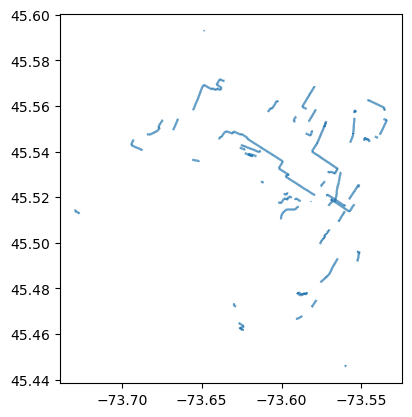

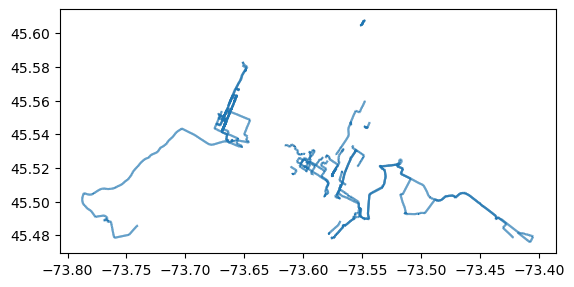

In [23]:
short_dt.plot()
long_dt.plot()
plt.show()

In [24]:
gdf.drop(columns=["dt_ind","dt_same", "vel_ind","vel_same"], inplace=True)

In [25]:
#gdf_savepoint = gdf.copy()
#gdf = gdf_savepoint.copy()

## note on methods
Since alot of these values we want to add are the same for all points in a trip (mean length for example)
I've come up a way of only having to to the calculation once and then adding the value to all datapoints in the trip. 

I do it all the time, so I thought I'd explain the method once:
* create new column which will hold the value, set all elements to NaN
* "loc" onto all first elements in trip and assign the correct value: 
* use "forwardfill" to fill all later NaN-values with this value, until another "real" value shows up


To access a value with loc we can write
                
         gdf.loc[gdf.groupby(level=0).head(1).index]["mean"]
but to permanently assign the value we must write 
         
         gdf.loc[gdf.groupby(level=0).head(1).index, "mean"] = x

This will fill all NaN-values and "inplace=True" means that we do it permanently
            
         fillna(method="ffill", inplace=True)

## dt
We now have the dt which is duration/tot_coord
and can add time to all segments
It is important to remember that the time we add corresponds to THE LAST coordinate in segment
(all segments contains two coordinates: start and end of)
we:
* calculate the mean dt for all trips and set dt_tillf
* set dt to dt_tillf but in datetime
* find how much datetime the coordinate is from the start of the trip: "end_timestamp"
* let the time "t" of the point be start-time of trip + end_timestamp

we dont drop stuff just yet, because we will need them in a sec to take care of the first segment in each trip (remember, its starting point is actually the endpoint of the trip)

In [26]:
gdf["dt_tillf"] = ((gdf.groupby(level=0)["duration"].mean()).sum())/((gdf.groupby(level=0)["n_coord"].mean()).sum())

gdf["dt"] = gdf["dt_tillf"].apply(lambda x: timedelta(seconds=x))

gdf["end_timestamp"] = gdf.groupby(level=0, group_keys=False)["dt"].cumsum()
gdf.drop("dt_tillf", axis=1, inplace=True)

#timestamp AGAIN, FOR THE END COORDINATE OF THE SEGMENT
gdf["t"] = gdf["start"] + gdf["end_timestamp"]

## We cut up the trips
where we have any segments w/o gps.reading that are much longer than we expect.
Specifically longer than 38 meter (0.999 quantile)
and reindex accordingly

In [27]:
gdf.reset_index(level=0, inplace=True)
gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = 1 
gdf["long"] = gdf["long"].cumsum()
gdf["trajectory_id"] = gdf["level_0"] + gdf["long"]

gdf.set_index(["trajectory_id"], append=True, drop=False, inplace=True)
gdf = gdf.swaplevel().copy()

gdf["long"] = 0
gdf.loc[gdf["length"]>= gdf["length"].quantile(0.999), "long"] = np.nan
gdf.dropna(inplace=True)

gdf.drop(columns=["level_0", "long"], inplace=True)

# Now, unfortunately the Kalmanfilter needs point-geometry 
We will add an index to each trip which is the starting-point ("t"="start")
this needs to be handled separately because this coord should be the first in the segment after

In [28]:
gdf.head(3)

stop  id_origine               start  \
trajectory_id                                                         
0             1 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              2 2013-06-25 16:34:16          52 2013-06-25 16:21:21   
              3 2013-06-25 16:34:16          52 2013-06-25 16:21:21   

                    length  purpose  n_coord  id  duration  \
trajectory_id                                                
0             1   3.259530  Commute      511  52     775.0   
              2  11.615175  Commute      511  52     775.0   
              3  14.267484  Commute      511  52     775.0   

                                                               geo  \
trajectory_id                                                        
0             1  LINESTRING (-73.57748 45.50690, -73.57751 45.5...   
              2  LINESTRING (-73.57751 45.50692, -73.57757 45.5...   
              3  LINESTRING (-73.57757 45.50701, -73.57774 45.5...   

                                    dt          end_timestamp  \
trajectory_id                                                   
0             1 0 days 00:00:01.172502 0 days 00:00:01.172502   
              2 0 days 00:00:01.172502 0 days 00:00:02.345004   
              3 0 days 00:00:01.172502 0 days 00:00:03.517506   

                                         t  trajectory_id  
trajectory_id                                              
0             1 2013-06-25 16:21:22.172502              0  
              2 2013-06-25 16:21:23.345004              0  
              3 2013-06-25 16:21:24.517506              0

In [ ]:
#coordinates = gdf.geometry.apply(lambda x: np.array(x.coords[0]))
#gdf.loc[gdf["end_timestamp"] == datetime.timedelta(seconds=0), "id_origine"] = np.nan

#gdf.dropna(inplace=True)

#Copy all first points
gdf_test= gdf.copy()
gdf_head = gdf_test.groupby(level=0).head(1).copy()

#change timestamps
gdf_head["end_timestamp"] = timedelta(seconds=0)
gdf_head["t"] = gdf_head["start"]
#set the segment to a line between start and start-point (so that x[0].coords[1] = x[1].coords[0])
gdf_head["geo"] = gdf_head["geo"].apply(lambda x: LineString([Point(x.coords[0]), Point(x.coords[0])]))
gdf_head["length"] = 0
#Change indexing so concat works
gdf_head.reset_index(level=1,drop=True,inplace=True)
gdf_head.set_index(pd.Index([0 for x in range(len(gdf_head))]), append=True,inplace=True)
#concat (add) the two df together, and sort index
gdf_done = pd.concat([gdf_head, gdf_test])
gdf_done.sort_index(inplace=True)

In [1351]:
#Keep going
#gdf = gdf_done.copy()

In [29]:
#create new column with last coord in segment as point
gdf["geometry"] = gdf["geo"].apply(lambda x: Point(x.coords[1]))

#change geom to point
gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [30]:
gdf_done = gdf.copy() #SAVE HERE IF YOU MESS UP :)

In [31]:
gdf.drop(columns=["n_coord", "start", "stop", "end_timestamp"], inplace=True)

gdf["id"] = [x for x in range(len(gdf))]
gdf.set_index(["id"], inplace=True,
             append=True, drop=False)


In [32]:
gdf.head(1)

id_origine   length  purpose  id  duration  \
trajectory_id   id                                               
0             1 0           52  3.25953  Commute   0     775.0   

                                                                  geo  \
trajectory_id   id                                                      
0             1 0   LINESTRING (-73.57748 45.50690, -73.57751 45.5...   

                                       dt                          t  \
trajectory_id   id                                                     
0             1 0  0 days 00:00:01.172502 2013-06-25 16:21:22.172502   

                    trajectory_id                    geometry  
trajectory_id   id                                             
0             1 0               0  POINT (-73.57751 45.50692)

In [33]:
gdf.reset_index(level=0,drop=True, inplace=True)
gdf.reset_index(level=0,drop=True, inplace=True)

In [34]:
gdf.head(3)

id_origine     length  purpose  id  duration  \
id                                                 
0           52   3.259530  Commute   0     775.0   
1           52  11.615175  Commute   1     775.0   
2           52  14.267484  Commute   2     775.0   

                                                  geo                     dt  \
id                                                                             
0   LINESTRING (-73.57748 45.50690, -73.57751 45.5... 0 days 00:00:01.172502   
1   LINESTRING (-73.57751 45.50692, -73.57757 45.5... 0 days 00:00:01.172502   
2   LINESTRING (-73.57757 45.50701, -73.57774 45.5... 0 days 00:00:01.172502   

                            t  trajectory_id                    geometry  
id                                                                        
0  2013-06-25 16:21:22.172502              0  POINT (-73.57751 45.50692)  
1  2013-06-25 16:21:23.345004              0  POINT (-73.57757 45.50701)  
2  2013-06-25 16:21:24.517506              0  POINT (-73.57774 45.50705)

# RUN BEFORE SHUTTING OFF

In [35]:
gdf_save2 = gdf.copy()

gdf_save2.to_csv('gdf_beforeKM.csv')

#gdf = pd.read_csv('gdf_firstsave.csv')
#gdf.set_index(["t"],inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [2]:
gdf = pd.read_csv('gdf_beforeKM.csv')
gdf.drop("id.1", axis=1, inplace=True)
gdf = gpd.GeoDataFrame(gdf)
gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')


# So far the only thing we have done with the data is to decide how to interpret the size of the timestep.
This is not unimportant and will effect the data alot
but still, most of the code above is just reading and parsing data.

# KalmanFilter

In [36]:
mpd.show_versions()


MovingPandas 0.17.0

SYSTEM INFO
-----------
python     : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:39:40) [Clang 15.0.7 ]
executable : /Users/johannaskantorp/opt/anaconda3/envs/movingpandas/bin/python
machine    : macOS-11.7.8-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.7.0
GDAL data dir: /Users/johannaskantorp/opt/anaconda3/envs/movingpandas/share/gdal
PROJ       : 9.2.1
PROJ data dir: /Users/johannaskantorp/opt/anaconda3/envs/movingpandas/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 2.0.3
fiona      : 1.9.4
numpy      : 1.24.4
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.7.2
mapclassify: 2.5.0
geopy      : 2.3.0
holoviews  : 1.17.0
hvplot     : 0.8.3
geoviews   : 1.10.1
stonesoup  : 1.0


## First we smooth with three different process noise std's
And this would take so long we only do it to the first 1000 trips in the dataset

In [59]:
gdf_std = gdf.loc[gdf["trajectory_id"]<=1000].copy()

t = time.time()

tc_t = mpd.TrajectoryCollection(gdf_std, 'trajectory_id', t='t')
print("Making the gdf a TrajectoryCollection takes", round(time.time()-t), "seconds")
stds = [0.1,0.3,0.5]
filename = ["smooth1000_01.csv", "smooth1000_03.csv","smooth1000_05.csv"]
gdfs = []

for i in range(len(stds)):
    std = stds[i]
    name = filename[i]
    
    smooth_t = mpd.KalmanSmootherCV(tc_t).smooth(process_noise_std=std, measurement_noise_std=10)
    smooth_t.add_speed()
    frame = smooth_t.to_point_gdf()
    frame.to_csv(name)
    gdfs.append(smooth_t.to_point_gdf())
    print("Finished with std", std, "total time:", round(time.time()-t), "seconds")
tc_t.add_speed()

Making the gdf a TrajectoryCollection takes 16 seconds
Finished with std 0.1 total time: 2340 seconds
Finished with std 0.3 total time: 4188 seconds
Finished with std 0.5 total time: 6034 seconds


In [60]:
frame = tc_t.to_point_gdf()

frame.to_csv("tc_1000.csv")
gdfs.append(frame)

# compare smoothing
"gdfs" contain the above

Here we need to test, and make a decision which parameters to choose. 
Still to be done!

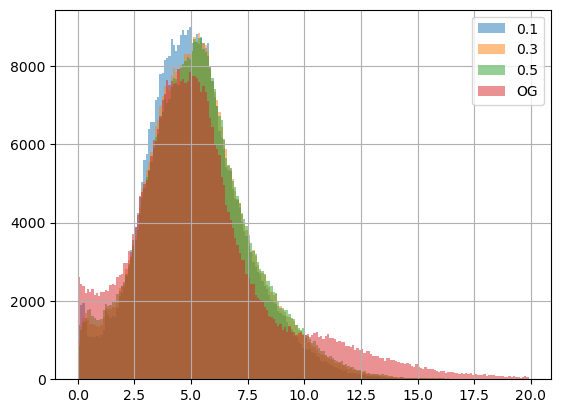

In [61]:
label = [str(x) for x in stds] + ["OG"]

for i in range(len(gdfs)):
    frame = gdfs[i]
    
    frame["speed"].hist(bins=[x*0.1 for x in range(200)], label=label[i], alpha = 0.5)
    
plt.legend()
plt.show()

I've looked at this further down, but it appears that the data is polluted with quite a lot of "walking". i.e., it def. looks like two distributions (one of walkers, one of cyclists)

# Make a decicion on which to use
Again, needs to be motivated,
currently running with: 
* process_noise_std=2, 
* measurement_noise_std=10

In [127]:
gdf_test = gdf.copy()#.loc[gdf["trajectory_id"]<=2].copy() #gdf.copy()#
gdf_test.drop(columns=["geo"], inplace=True)

In [128]:
std=2.5
tc = mpd.TrajectoryCollection(gdf_test, 'trajectory_id', t='t')
#smooth = mpd.KalmanSmootherCV(tc).smooth(process_noise_std=std, measurement_noise_std=10)
#smooth.add_speed()

In [129]:
tc.add_speed()
tc_save = tc.to_point_gdf()

In [7]:
gm = smooth.to_point_gdf()

In [130]:
tc_save

id  id_origine     length     purpose  \
t                                                                        
2013-06-25 16:21:22.172502        0          52   3.259530     Commute   
2013-06-25 16:21:23.345004        1          52  11.615175     Commute   
2013-06-25 16:21:24.517506        2          52  14.267484     Commute   
2013-06-25 16:21:25.690008        3          52  21.120836     Commute   
2013-06-25 16:21:26.862510        4          52  18.383815     Commute   
...                             ...         ...        ...         ...   
2015-08-31 14:47:39.315108  4297178       28938   6.976099  Magasinage   
2015-08-31 14:47:40.487610  4297179       28938   8.120286  Magasinage   
2015-08-31 14:47:41.660112  4297180       28938   8.767340  Magasinage   
2015-08-31 14:47:42.832614  4297181       28938   7.957226  Magasinage   
2015-08-31 14:47:44.005116  4297182       28938   2.979232  Magasinage   

                            duration                      dt  trajectory_id  \
t                                                                             
2013-06-25 16:21:22.172502     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:23.345004     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:24.517506     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:25.690008     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:26.862510     775.0  0 days 00:00:01.172502              0   
...                              ...                     ...            ...   
2015-08-31 14:47:39.315108     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:40.487610     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:41.660112     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:42.832614     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:44.005116     102.0  0 days 00:00:01.172502           9182   

                                              geometry      speed  
t                                                                  
2013-06-25 16:21:22.172502  POINT (-73.57751 45.50692)   9.759812  
2013-06-25 16:21:23.345004  POINT (-73.57757 45.50701)   9.759812  
2013-06-25 16:21:24.517506  POINT (-73.57774 45.50705)  11.988455  
2013-06-25 16:21:25.690008  POINT (-73.57792 45.50718)  17.747088  
2013-06-25 16:21:26.862510  POINT (-73.57810 45.50729)  15.447276  
...                                                ...        ...  
2015-08-31 14:47:39.315108  POINT (-73.54475 45.54151)   5.862707  
2015-08-31 14:47:40.487610  POINT (-73.54478 45.54145)   6.824278  
2015-08-31 14:47:41.660112  POINT (-73.54482 45.54137)   7.368059  
2015-08-31 14:47:42.832614  POINT (-73.54486 45.54131)   6.687238  
2015-08-31 14:47:44.005116  POINT (-73.54490 45.54130)   2.503741  

[4297041 rows x 9 columns]

In [142]:
#gm = gdfs[1]

# Stops
we define a stop as not moving outside of a diameter of 30 meters in 20 seconds
this might be a bad choice - look into further

In [8]:
detector = mpd.TrajectoryStopDetector(smooth)
#detector = mpd.TrajectoryStopDetector(smooth_t)
stops = detector.get_stop_segments(min_duration=timedelta(seconds=20), max_diameter=30)
gdf_stops = stops.to_point_gdf()

In [9]:
gdf_stops.head(3) #HHHHH

id  id_origine    length  purpose  duration  \
t                                                                         
2013-06-25 16:21:50.312550  24          52  4.628739  Commute     775.0   
2013-06-25 16:21:51.485052  25          52  6.599325  Commute     775.0   
2013-06-25 16:21:52.657554  26          52  1.447080  Commute     775.0   

                                                dt  \
t                                                    
2013-06-25 16:21:50.312550  0 days 00:00:01.172502   
2013-06-25 16:21:51.485052  0 days 00:00:01.172502   
2013-06-25 16:21:52.657554  0 days 00:00:01.172502   

                                           trajectory_id  \
t                                                          
2013-06-25 16:21:50.312550  0_2013-06-25 16:21:50.312550   
2013-06-25 16:21:51.485052  0_2013-06-25 16:21:50.312550   
2013-06-25 16:21:52.657554  0_2013-06-25 16:21:50.312550   

                                              geometry     speed  
t                                                                 
2013-06-25 16:21:50.312550  POINT (-73.57731 45.50875)  4.681327  
2013-06-25 16:21:51.485052  POINT (-73.57729 45.50878)  3.319098  
2013-06-25 16:21:52.657554  POINT (-73.57727 45.50880)  2.118900

In [10]:
#but_point = gdf_stops.set_index(["trajectory_id"], inplace=False,
#             append=True, drop=False).groupby(level=1)["speed"].idxmin().tolist()
but_point = gdf_stops.set_index(["trajectory_id"], inplace=False,
             append=True, drop=False).swaplevel().groupby(level=0)["speed"].idxmin().tolist()

In [11]:
cut_point = [x[1] for x in but_point]

Create a column which 
* = 1 if part of stop
* = 0 if not
* = 2 if third coord in the stop, which is what I decided on as my cutting point. 
Motivation for cutting point: I thought about using the lowest vel in stop, but decided on wanting to use the first coord (maybe wrong). why not first: wanted to increase likelihood of being a low number (first coord probably a little higher)

In [12]:
gm["stop"] = 0
gm.loc[gdf_stops.index, "stop"] = 1
gm.loc[cut_point, "stop"] = 2

## save point

In [3]:
#gdf_save1 = gdf.copy()

#gm.to_csv('gm_KM03.csv')
#tc_save.to_csv("tc_collection.csv")
#gm.to_csv("gm_KM2_5.csv")
#gdf = pd.read_csv('gdf_firstsave.csv')
#gdf.set_index(["t"],inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [4]:
#gm = pd.read_csv("gm_KM2_5.csv")

In [8]:
#gm["geometry"] = gm['geometry'].apply(wkt.loads)

In [9]:
#gm.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [10]:
#gm

id  id_origine     length     purpose  \
t                                                                        
2013-06-25 16:21:22.172502        0          52   3.259530     Commute   
2013-06-25 16:21:23.345004        1          52  11.615175     Commute   
2013-06-25 16:21:24.517506        2          52  14.267484     Commute   
2013-06-25 16:21:25.690008        3          52  21.120836     Commute   
2013-06-25 16:21:26.862510        4          52  18.383815     Commute   
...                             ...         ...        ...         ...   
2015-08-31 14:47:39.315108  4297178       28938   6.976099  Magasinage   
2015-08-31 14:47:40.487610  4297179       28938   8.120286  Magasinage   
2015-08-31 14:47:41.660112  4297180       28938   8.767340  Magasinage   
2015-08-31 14:47:42.832614  4297181       28938   7.957226  Magasinage   
2015-08-31 14:47:44.005116  4297182       28938   2.979232  Magasinage   

                            duration                      dt  trajectory_id  \
t                                                                             
2013-06-25 16:21:22.172502     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:23.345004     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:24.517506     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:25.690008     775.0  0 days 00:00:01.172502              0   
2013-06-25 16:21:26.862510     775.0  0 days 00:00:01.172502              0   
...                              ...                     ...            ...   
2015-08-31 14:47:39.315108     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:40.487610     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:41.660112     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:42.832614     102.0  0 days 00:00:01.172502           9182   
2015-08-31 14:47:44.005116     102.0  0 days 00:00:01.172502           9182   

                                              geometry      speed  stop  
t                                                                        
2013-06-25 16:21:22.172502  POINT (-73.57764 45.50701)   3.017804     0  
2013-06-25 16:21:23.345004  POINT (-73.57767 45.50703)   3.017804     0  
2013-06-25 16:21:24.517506  POINT (-73.57777 45.50708)   8.149587     0  
2013-06-25 16:21:25.690008  POINT (-73.57790 45.50716)  11.506679     0  
2013-06-25 16:21:26.862510  POINT (-73.57805 45.50725)  12.814298     0  
...                                                ...        ...   ...  
2015-08-31 14:47:39.315108  POINT (-73.54475 45.54150)   5.692212     0  
2015-08-31 14:47:40.487610  POINT (-73.54479 45.54144)   5.857093     0  
2015-08-31 14:47:41.660112  POINT (-73.54482 45.54139)   5.890508     0  
2015-08-31 14:47:42.832614  POINT (-73.54486 45.54133)   5.782137     0  
2015-08-31 14:47:44.005116  POINT (-73.54489 45.54128)   5.647423     0  

[4297041 rows x 10 columns]

# start from here

In [3]:
#gm = pd.read_csv('gm_kf.csv')
gm = pd.read_csv("gm_KM2_5.csv")
gm.set_index(["t"],inplace=True)
gm = gpd.GeoDataFrame(gm)
gm["geometry"] = gm['geometry'].apply(wkt.loads)

gm.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [4]:
tc_save = pd.read_csv('OG_kf.csv')
tc_save.set_index(["t"],inplace=True)

tc_save = gpd.GeoDataFrame(tc_save)
tc_save["geometry"] = tc_save['geometry'].apply(wkt.loads)

tc_save.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

In [5]:
gm.head(3)

id  id_origine     length  purpose  duration  \
t                                                                          
2013-06-25 16:21:22.172502   0          52   3.259530  Commute     775.0   
2013-06-25 16:21:23.345004   1          52  11.615175  Commute     775.0   
2013-06-25 16:21:24.517506   2          52  14.267484  Commute     775.0   

                                                dt  trajectory_id  \
t                                                                   
2013-06-25 16:21:22.172502  0 days 00:00:01.172502              0   
2013-06-25 16:21:23.345004  0 days 00:00:01.172502              0   
2013-06-25 16:21:24.517506  0 days 00:00:01.172502              0   

                                              geometry     speed  stop  
t                                                                       
2013-06-25 16:21:22.172502  POINT (-73.57764 45.50701)  3.017804     0  
2013-06-25 16:21:23.345004  POINT (-73.57767 45.50703)  3.017804     0  
2013-06-25 16:21:24.517506  POINT (-73.57777 45.50708)  8.149587     0

In [6]:
gm_savepoint = gm.copy()

In [7]:
gm.set_index(["trajectory_id"], inplace=True,
             append=True, drop=True)
gm = gm.reorder_levels(["trajectory_id", "t"]).copy()

In [8]:
#create a column which is dt but in seconds
gm["time"] = pd.to_timedelta(gm["dt"]).dt.total_seconds()
gm.rename(columns={"speed":"vel"}, inplace=True)

In [9]:
gm["timesum"] = gm.groupby(level=0)["time"].cumsum()

In [10]:
tc_save.set_index(["trajectory_id"], inplace=True,
             append=True, drop=True)
tc_save = tc_save.reorder_levels(["trajectory_id", "t"]).copy()

In [11]:
#create a column which is dt but in seconds
tc_save["time"] = pd.to_timedelta(tc_save["dt"]).dt.total_seconds()
tc_save.rename(columns={"speed":"vel"}, inplace=True)

In [12]:
tc_save["timesum"] = tc_save.groupby(level=0)["time"].cumsum()
v_use = "vel"
acc_name = "acc"

tc_save[acc_name] = -tc_save.groupby(level=0, group_keys=False)[v_use].apply(lambda x: x.diff(periods=-1))
tc_save[acc_name] = tc_save.loc[:, (acc_name)]/gm.loc[:, ("time")]

#the first/last elem in each trip is NaN so we replace it with zero
tc_save[acc_name].fillna(0, inplace=True)

# Elevation
This takes some time, and should not be done if we decide not to use

In [53]:
##Create a grid of all data-points available, with corresponding elevation.
##interp is now a function that we can put lat-long into and get the interpolated elevation in that point
lat = np.array(df_el["lat"].unique().tolist())
long = df_el["long"].unique().tolist()
xg, yg = np.meshgrid(lat, long, indexing='ij')

##1474 long append 1843 of them
elev = []
for i in range(1843):
    elev.append(df_el.loc[df_el["lat"]==(df_el["lat"][i])]["elevation"].tolist())



interp = RegularGridInterpolator((lat, long), elev,
                                 bounds_error=False, fill_value=None)

In [54]:
#we find the elevation of the FIRST coord [0] in the segment, so later, 
#if we want incline over segment we should compare it to the elevation in the NEXT row
#this is somewhat incorrect since we will have the geo in points.. change accordingly


coordinates = gm.geometry.apply(lambda x: np.array(x.coords[0]))
pts =  np.array(coordinates.tolist())

elevation_list = interp(pts)

gm["elev_start"] = elevation_list

In [55]:
coordinates = tc_save.geometry.apply(lambda x: np.array(x.coords[0]))
pts =  np.array(coordinates.tolist())

elevation_list = interp(pts)

tc_save["elev_start"] = elevation_list

In [ ]:
#gm["scaled_elev"] = gm["elev_start"]/10
#N = 9

#fig = plt.figure(figsize=(25, 5*round(N/3)))
#num = 5
#for i in range(N):
#    plt.subplot(round(N/3),3,i+1)
#    plt.xlabel("time")
#    plt.ylabel("elevation")
#    x = gm.groupby(level=0).get_group(i+num)["time_ind"].cumsum().tolist()
    plt.plot(x, gm.groupby(level=0).get_group(i+num)["vel_og"], alpha=0.5)
    y = gm.groupby(level=0).get_group(i+num)["scaled_elev"].tolist()
    x = [0] + x + [x[-1]]
    y = [0] + y + [0]
    plt.plot(x, y, color="red")
    plt.fill(x, y,[0 for y in x], color="red", alpha = 0.3)
    #section = np.arange(-1, 1, 1/20.)
    #plt.fill_between(section,f(section))
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 1000])
    plt.ylim([0,20])
    #plt.title("trip #"+str(trip))

plt.show()

## End of elevation (for now)

In [56]:
#gdf_save1 = gdf.copy()

gm.to_csv('gm_elev_KM03.csv')
tc_save.to_csv("tc_elev_collection.csv")

#gdf = pd.read_csv('gdf_firstsave.csv')
#gdf.set_index(["t"],inplace=True)
#gdf = gpd.GeoDataFrame(gdf)
#gdf["geometry"] = gdf['geometry'].apply(wkt.loads)

#gdf.set_geometry("geometry", drop=False, inplace=True, crs='epsg:4617')

# Done

Meet your dataframe:
Currently it consists of 
* trip index (level=0)
* segment index (level=1)
* purpose of trip
* trajectory_id; relic of kalmanfilter
* duration; [s] according to og data 
* geo; two coordinates denoting a linesegment
* count; denotes how many timesteps this segment is considered to be. Most are 1
* tot_coord; total coordinates of trip, affected the dt, but now not needed
* dt; time in datetime
* geometry; point geometry
* id; relic of kalmanfilter
* length; [m] length of linesegment: NO LONGER TRUE AFTER SMOOTHING
* vel; [m/s] vel after smoothing
* stop; 1 if point is part of a stop, 0 else, 2 if cutting point
* time; mean time between GPS readings (set to 1.5 seconds for all readings)



* elev; [m] elevation in first point of linestring/point geom

## Let's put the trips back together
The only reason we cut them was to not give any weigth to the segments where we lost contact

First of all, the smoothing function starts at zero, so we need to cut the ~first half minute from all trips
First we add acceleration,
Then we remove everything up to the point that acceleration is strictly positive
or the first minute - whichever comes first

In [14]:
v_use = "vel"
acc_name = "acc"

gm[acc_name] = -gm.groupby(level=0, group_keys=False)[v_use].apply(lambda x: x.diff(periods=-1))
gm[acc_name] = gm.loc[:, (acc_name)]/gm.loc[:, ("time")]

#the first/last elem in each trip is NaN so we replace it with zero
gm[acc_name].fillna(0, inplace=True)

In [15]:
gm["drop"] = np.nan
gm.loc[gm["timesum"]>60, "drop"] = 1
gm.loc[gm["acc"]<0, "drop"] = 1
gm["drop"] = gm.groupby(level=0)["drop"].cumsum()
gm.dropna(inplace=True)
gm.drop("drop", axis=1, inplace=True)
gm.set_index("id_origine", inplace=True, append=True, drop=False)
gm.reset_index("trajectory_id", inplace=True)
gm = gm.reorder_levels(["id_origine", "t"]).copy()

In [16]:
gm["timesum"] = gm.groupby(level=0)["time"].cumsum()
gm["timesum"] = gm["timesum"] - gm["time"]
#set all to NaN
gm["duration"] = np.nan
#set last elem in group to its timesum-value = the duration of this MT
gm.loc[gm.groupby(level=0).tail(1).index, "duration"] = gm.groupby(level=0).tail(1)["timesum"].tolist()
gm["duration"].fillna(method="bfill",inplace=True)

In [ ]:
#gm[["vel", "acc"]].to_csv('gm_histo_clean.csv')

vel       acc
id_origine t                                              
52         2013-06-25 16:21:26.862510  12.814298 -0.436593
           2013-06-25 16:21:28.035012  12.302391 -1.501606
           2013-06-25 16:21:29.207514  10.541754 -1.869684
           2013-06-25 16:21:30.380016   8.349546 -1.588744
           2013-06-25 16:21:31.552518   6.486741 -0.760610
...                                          ...       ...
28938      2015-08-31 14:47:39.315108   5.692212  0.140623
           2015-08-31 14:47:40.487610   5.857093  0.028499
           2015-08-31 14:47:41.660112   5.890508 -0.092428
           2015-08-31 14:47:42.832614   5.782137 -0.114894
           2015-08-31 14:47:44.005116   5.647423  0.000000

[4090474 rows x 2 columns]

## What to cut?

Suggestions:
* Trips shorter than 60 seconds
* Trips with mean velocity over x m/s (suggestion 11 m/s)
* Trips with mean velocity under x m/s ()
* Trips that never exceed x m/s
* Trips that exceed certain speeds for a majority of the time?

We look at these aspects but do not make any cuts at this time

In [23]:
gm_nocut = gm.copy()

In [55]:
mintime = 180
maxtime = 2*3600
short_time = round(gm.loc[gm["duration"]<mintime].groupby(level=0).head(1).duration.sum()/3600,2)
long_time = round(gm.loc[gm["duration"]>maxtime].groupby(level=0).head(1).duration.sum()/3600,2)
short_num = len(gm.loc[gm["duration"]<mintime].groupby(level=0).head(1))
long_num = len(gm.loc[gm["duration"]>maxtime].groupby(level=0).head(1))
short_mean = round(gm.loc[gm["duration"]<mintime]["vel"].mean(), 2)
long_mean = round(gm.loc[gm["duration"]>maxtime]["vel"].mean(), 2)
velmean = round(gm["vel"].mean(),5)
print("we have", short_time, "hours of <3 minute-trips, and", long_time, "hours of >2 hour-trips")
print("we have", short_num, "trips in total that are <3 minute, and", long_num, "trips in total that are >2 hour-trips")
print("the mean vel for short trips are", short_mean, ", and the mean vel for long ones are", long_mean, ". Overall mean:", velmean)

In [43]:
#keep only trips over 3 minutes and below 2 hours
#This is how to make the cut
#gm = gm.loc[(gm["duration"]>mintime) & (gm["duration"]<maxtime)].copy()

In [38]:
#3 highest mean velocities
N = 3
gm.groupby(level=0)["vel"].mean().nlargest(N)

id_origine
972      17.832129
3601     13.616123
15991    12.252765
Name: vel, dtype: float64

In [39]:
#three lowest mean velocities
N=3
gm.groupby(level=0)["vel"].mean().nsmallest(N)

id_origine
1525     0.541155
14227    0.790919
1128     0.802087
Name: vel, dtype: float64

In [40]:
#three lowest max velocities
N=3
gm.groupby(level=0)["vel"].max().nsmallest(N)

id_origine
14607    1.383076
14227    1.585887
11823    1.802477
Name: vel, dtype: float64

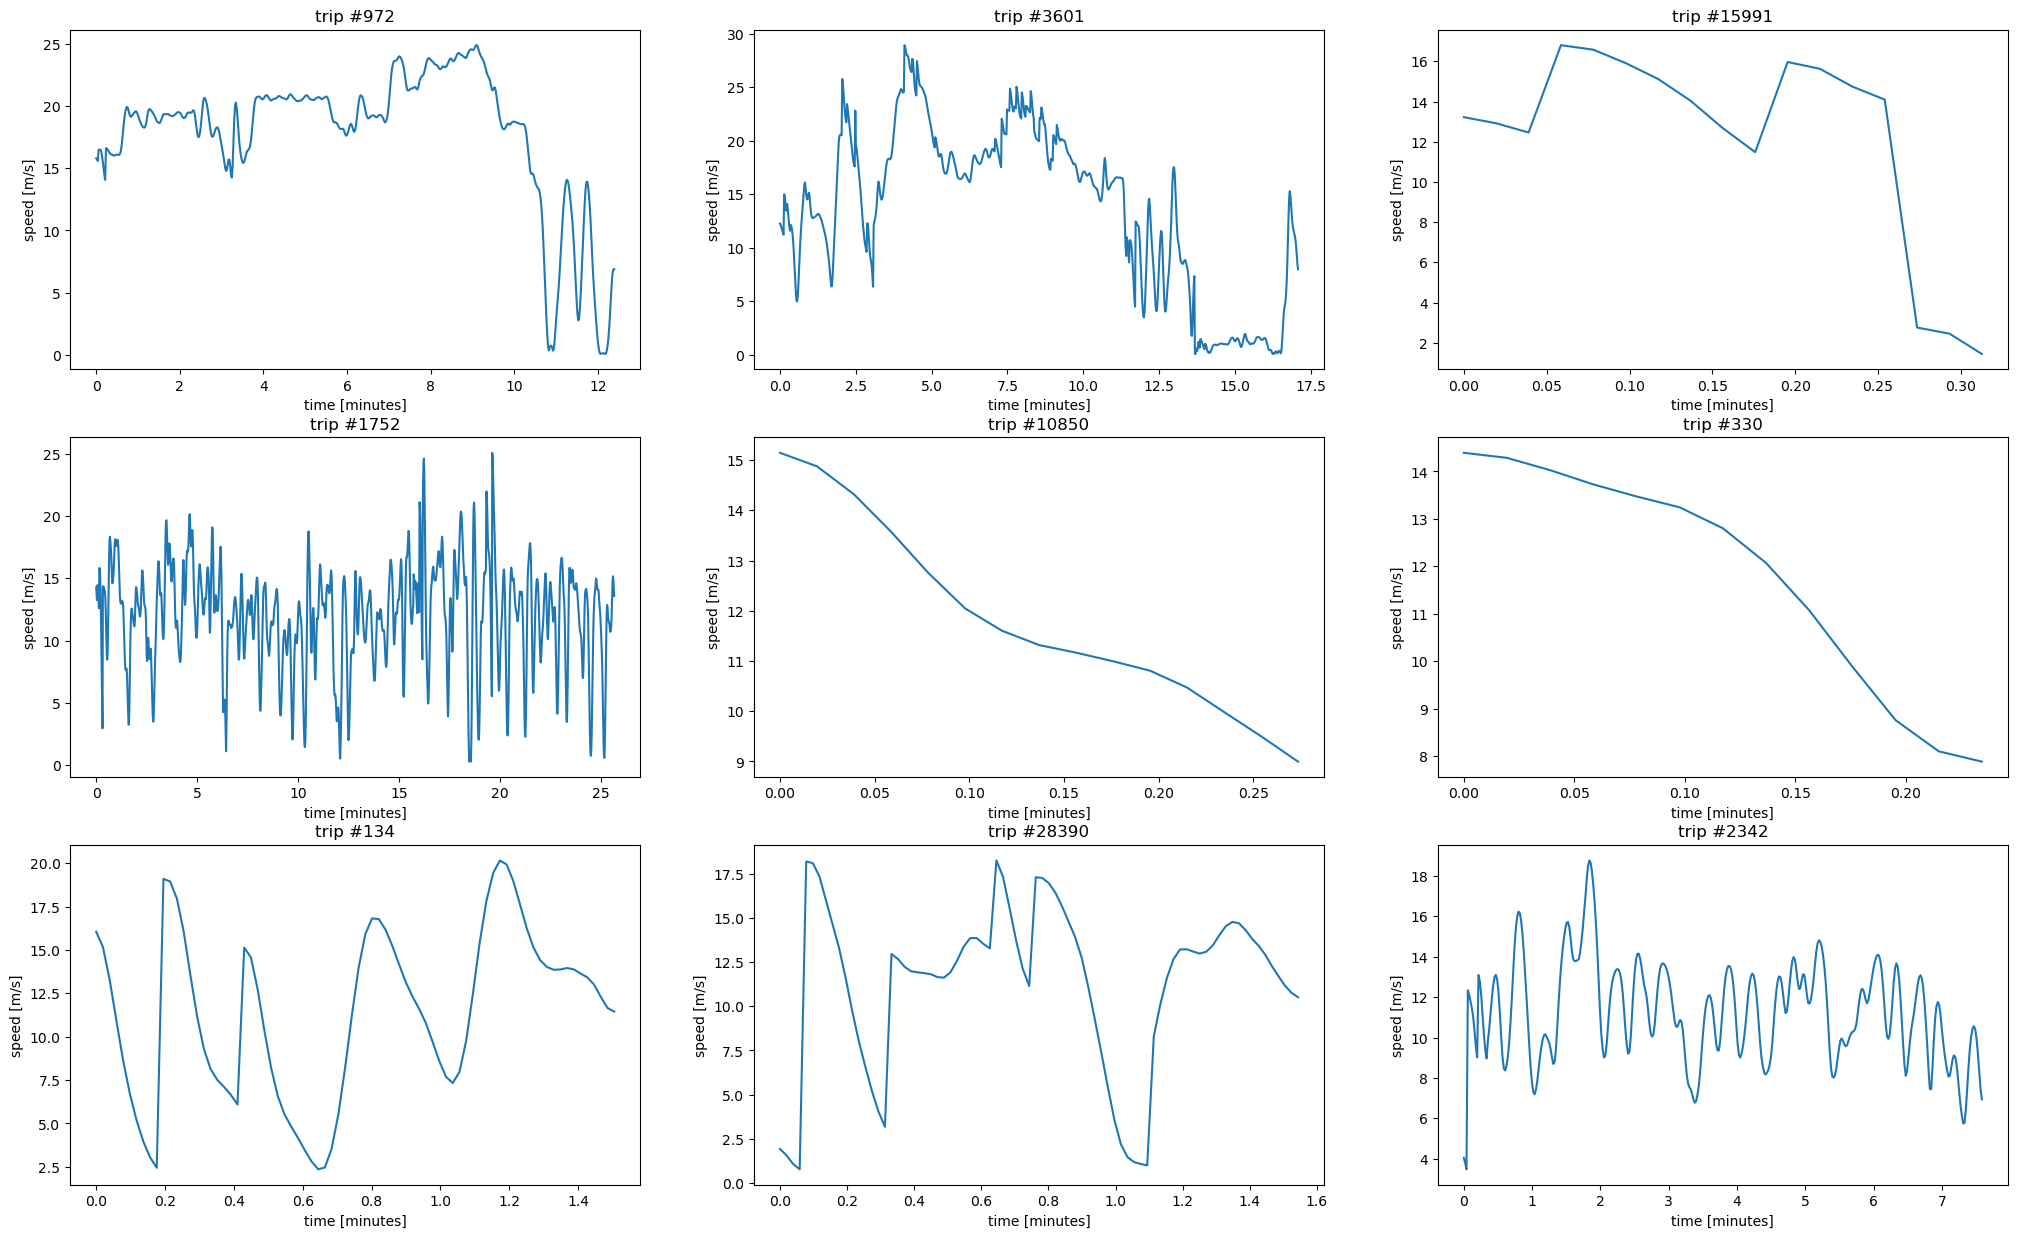

In [41]:
#paste any of the ones above to view the plot of the N trips

N = 9

trip_ids = gm.groupby(level=0)["vel"].mean().nlargest(N).index.tolist()
trips = [x for x in range(N)]


fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[i]#[trips[i]]
    times = [x/60 for x in gm.xs(trip)["timesum"].tolist()]
    vels = gm.xs(trip)["vel"].tolist()
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

In [579]:
#to drop trips with mean velocities over a certain value, do the following
#val = 8.333
#trips = (gm.groupby(level=0)["vel"].mean() < val)[(gm.groupby(level=0)["vel"].mean() < val)].index.tolist()
#gm = gm.loc[trips].copy()

## Get the data for the opt

### velocity histogram

In [70]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_bin"
veel = []
#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,101):
    bin_edges.append(i/(5))
    veel.append(i/5)
    

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,101):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [71]:
#print H
H = gm.groupby("vel_bin")["vel_bin"].count().tolist()
print("H =", H)
print("vel =", veel)

H = [19289, 27440, 28553, 28778, 32884, 36911, 38281, 38100, 39344, 42125, 45264, 49186, 54991, 62176, 69883, 77608, 86103, 95135, 105143, 114510, 123438, 131706, 139065, 146250, 151083, 155181, 157308, 158119, 155163, 150211, 141913, 131853, 121910, 110837, 101092, 92116, 84092, 75223, 67934, 61045, 55119, 50234, 45873, 41963, 38178, 34532, 31383, 27938, 25053, 22302, 20078, 18138, 15860, 14042, 12433, 11233, 9684, 8560, 7500, 6630, 5882, 5059, 4330, 3969, 3367, 2973, 2563, 2164, 1937, 1645, 1442, 1238, 1112, 994, 846, 742, 653, 559, 479, 404, 413, 370, 313, 240, 218, 205, 164, 162, 132, 131, 142, 136, 108, 111, 98, 98, 98, 72, 60, 53]
vel = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 1

### acceleration quantiles

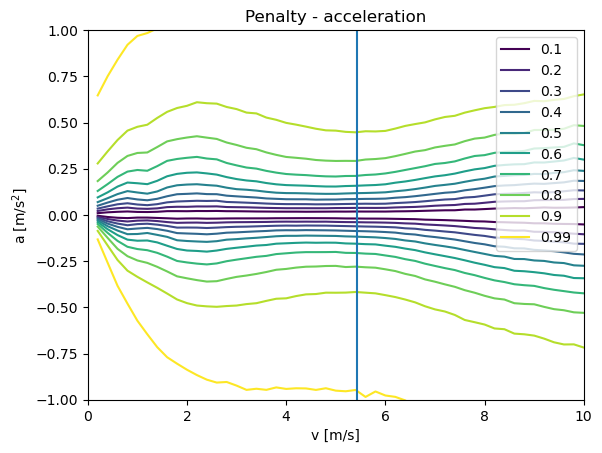

In [151]:
gm_plt_a = gm.loc[gm["acc"]>0].reset_index(drop=True)
gm_plt_d = gm.loc[gm["acc"]<0].reset_index(drop=True)

plt.xlabel("v [m/s]")
plt.ylabel("a [m/s$^2$]")
vv = 26

color=mcp.gen_color(cmap="viridis",n=10)


#print("quant: acc")
acc_l = []
dec_l = []
q_l = []
for i in range(9):
    q = (i + 1)/10

    plt.plot(veel, gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q)), "-", label=str(q), color=color[i])
    plt.plot(veel, gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q)), "-", color=color[i])
    accc = round(gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q))[vv],2)
    deccc = round(gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q))[vv],2)
    acc_l.append(accc)
    dec_l.append(deccc)
    q_l.append(q)
    #print(q,":", accc, "&", deccc)

q=0.99
plt.plot(veel, gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q)), "-", label=str(q), color=color[-1])
plt.plot(veel, gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q)), "-", color=color[-1])

accc = round(gm_plt_a.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(q))[vv],2)
deccc = round(gm_plt_d.groupby("vel_bin")["acc"].apply(lambda x: x.quantile(1-q))[vv],2)
acc_l.append(accc)
dec_l.append(deccc)
q_l.append(q)
#print(q,":", accc, "&", deccc)

plt.vlines([gm["vel"].mean()],-1,1)
plt.xlim([0,10])
plt.ylim([-1,1])
plt.legend()
plt.plot()
plt.title("Penalty - acceleration")


plt.show()

In [152]:
print("A =",acc_l+[100])
print("q =", q_l+[100])

A = [0.02, 0.04, 0.06, 0.09, 0.12, 0.16, 0.21, 0.29, 0.45, 1.07, 100]
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 100]


### Cruising time

In [72]:
print("percent cruising:", round(len(gm.loc[(gm["acc"]<0.1)&(gm["acc"]>-0.1)])/len(gm)*100, 2), "%")
print("percent accelerating:", round(len(gm.loc[(gm["acc"]>0)])/len(gm)*100, 2), "%")
print("percent decelerating:", round(len(gm.loc[(gm["acc"]<0)])/len(gm)*100, 2), "%")

percent cruising: 39.46 %
percent accelerating: 46.47 %
percent decelerating: 53.36 %


### stops
This is hard, because we can define it pretty much however we want
If we go by the definition from movingpandas we get that the mean time spent between stops is 10 minutes for a trip
and 6 minutes if we calculate as the total duration/total number of stops (MP stops)

If we instead go by each unique time we go below 2 m/s we get that the mean time between stops is 3 minutes. (UB2 stops)

Let's compare:

In [73]:
gm["MP_stop"] = 0
gm.loc[gm["stop"]==2, "MP_stop"] = 1
gm.loc[gm.groupby(level=0).head(1).index, "MP_stop"] = 1
#We add that the first element is a stop

In [74]:
print("total duration/total number of MP stops =", round(gm.groupby(level=0)["duration"].mean().sum()/gm["MP_stop"].sum()/60,2), "minutes")

total duration/total number of MP stops = 5.89 minutes


In [75]:
print("mean(trip duration/MP stops of trip) = ", round((gm.groupby(level=0)["duration"].mean()/(gm.groupby(level=0)["MP_stop"].sum())).mean()/60,2), "minutes")

mean(trip duration/MP stops of trip) =  8.83 minutes


In [76]:
gm["tst"] = 0
gm.loc[gm["vel"]<2,"tst"] = 1
gm["tt"] = gm["tst"].shift()
gm.loc[gm.groupby(level=0).head(1).index, "tt"] = 0
gm["tst"] = gm["tst"]-gm["tt"]
gm.loc[gm["tst"] == -1, "tst"] = 0
gm.loc[gm.groupby(level=0).head(1).index, "tst"] = 1
gm.drop(columns=["tt"], inplace=True)

In [77]:
print("total duration/total number of UB2 stops =", round(gm.groupby(level=0)["duration"].mean().sum()/gm["tst"].sum()/60,2), "minutes")

total duration/total number of UB2 stops = 2.26 minutes


In [78]:
print("mean(trip duration/UB2 stops of trip) = ", round((gm.groupby(level=0)["duration"].mean()/(gm.groupby(level=0)["tst"].sum())).mean()/60,2), "minutes")

mean(trip duration/UB2 stops of trip) =  2.99 minutes


If we compare the two methods using two illuminting trips we can see that they unfortunately work well in different scenarios

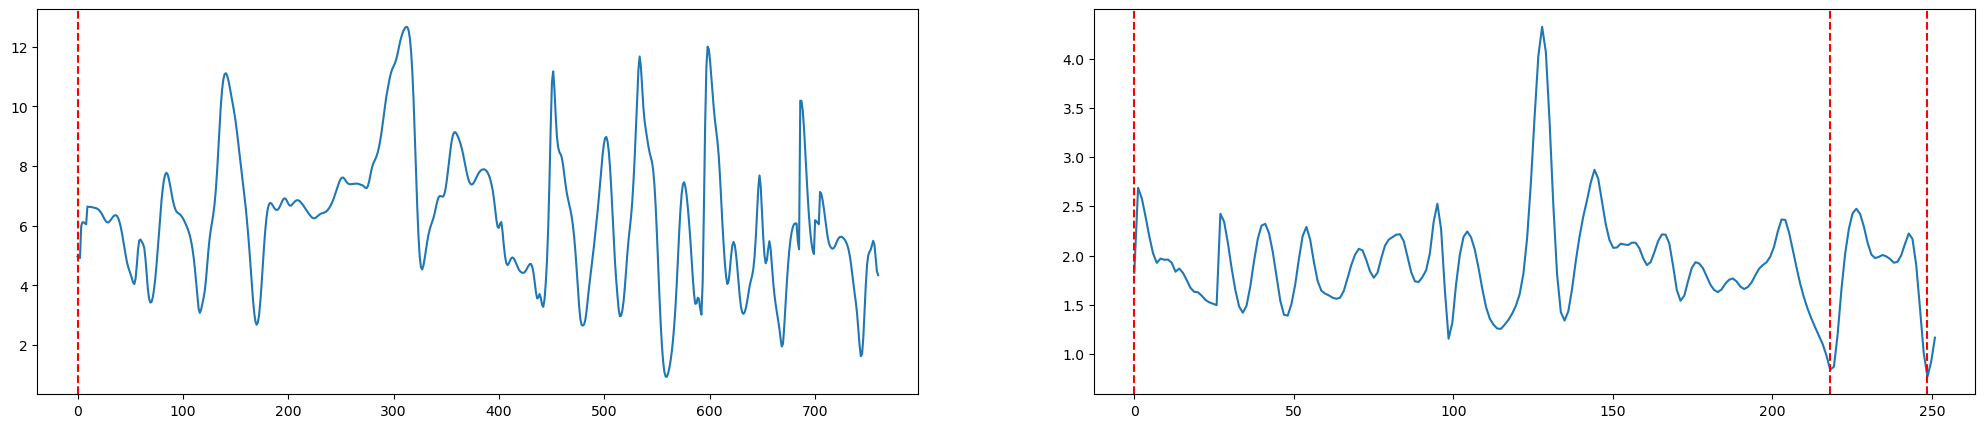

In [79]:
fig = plt.figure(figsize=(25, 5))


frame = gm.xs(56)
plt.subplot(1,2,1)
plt.plot(frame["timesum"], frame["vel"])
cut_plt = frame.loc[frame["MP_stop"] == 1]["timesum"].tolist()
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    
frame = gm.xs(10392)
plt.subplot(1,2,2)
plt.plot(frame["timesum"], frame["vel"])
cut_plt = frame.loc[frame["MP_stop"] == 1]["timesum"].tolist()
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    

plt.show()

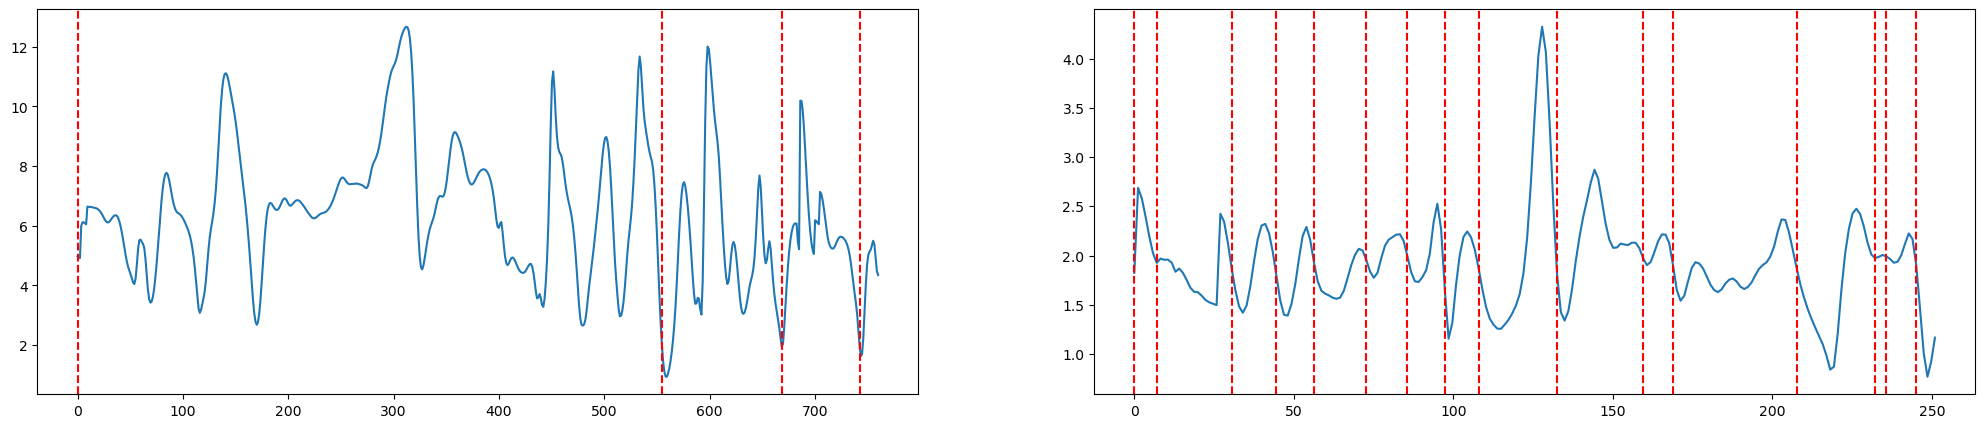

In [80]:
fig = plt.figure(figsize=(25, 5))


frame = gm.xs(56)
plt.subplot(1,2,1)
plt.plot(frame["timesum"], frame["vel"])
cut_plt = frame.loc[frame["tst"] == 1]["timesum"].tolist()
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    
frame = gm.xs(10392)
plt.subplot(1,2,2)
plt.plot(frame["timesum"], frame["vel"])
cut_plt = frame.loc[frame["tst"] == 1]["timesum"].tolist()
for xc in cut_plt:
    plt.axvline(x=xc, color="red", linestyle="--")
    

plt.show()

### idling time
We have a similar issue defining idling time, but if we set it to less than 2 m/s

In [81]:
print("percent idling time:", round(len(gm.loc[gm["vel"]<2])/len(gm)*100,2), "%")

percent idling time: 8.11 %


In [82]:
print("mean idle time per trip:", round((gm.loc[gm["vel"]<2].groupby(level=0)["id"].count()/gm.groupby(level=0)["id"].count()).mean()*100, 2), "%")

mean idle time per trip: 9.42 %


So for a trip of 25 minutes, approximately 2 minutes should be spent below 2m/s 

### mean vel etc

# The idea is to compare individual trips to the whole data-set. 

Things to compare:
* Mean acceleration
* Mean velocity
* Idling time/minute
* Idling time specifically around mean velocity/minute
* number of stops/minute
* time spent "stopping"/minute


## We will now analyze this data
We create a dataframe which we will fill with the characteristic parameters for each trip
* mean velocity
* mean acceleration
* mean deceleration
* percentage of idling time
* time spent accelerating
* time spend cruising
* max velocity
* max acceleration
* min (max) deceleration

There are of course other parameters that could be considered characteristic, such as "duration", "reason for trip", etc.

Also note that mean vel/acc/dec is calculated based on *number of occurences*, while operational modes are calculated based on *time spent in that mode*. Make a decision here as to how to handle this! (Maybe find a geometry with even dt)

(OG timestep as a param? No, but also maybe to see.. )

In [17]:
#create dataframe to keep track of unique values for all trips
gm_idx = pd.DataFrame(index=gm.index.unique(level=0).tolist())

In [18]:
#add mean vel, mean acc, mean dec to each MT
gm_idx["vel_mean"] = gm.groupby(level=0)["vel"].mean()

gm["pos_acc"] = gm["acc"]
gm.loc[gm["pos_acc"] < 0 , "pos_acc"] = np.nan
gm_idx["acc_mean"] = gm.groupby(level=0)["pos_acc"].mean()


gm["neg_acc"] = gm["acc"]
gm.loc[gm["neg_acc"] > 0 , "neg_acc"] = np.nan
gm_idx["dec_mean"] = gm.groupby(level=0)["neg_acc"].mean()

In [19]:
gm["idle"] = 0
gm.loc[gm["vel"]<2, "idle"] = 1

In [20]:
#add percentage of time spent idling
gm_idx["idle"] = gm.groupby(level=0)["idle"].sum()/gm.groupby(level=0)["id"].count()


#(gm["stop"]*gm["time"]).groupby(level=0).sum()/gm.groupby(level=0)["duration"].mean()

In [21]:
#time spent cruising
cruise_lim = 0.1 #[m/s^2]

gm["cruise"] = 1
gm.loc[gm["acc"] < -cruise_lim , "cruise"] = 0
gm.loc[gm["acc"] > cruise_lim , "cruise"] = 0

gm_idx["cruise"] = gm.groupby(level=0)["cruise"].sum()/gm.groupby(level=0)["id"].count()

#gm_idx["cruise"] = ((gm["cruise"]*gm["time"]).groupby(level=0).sum())/(gm.groupby(level=0)["duration"].mean())

#gm_idx["cruise"] = (gm.groupby(level=0)["cruise"].apply(lambda x: x.sum())/gm.groupby(level=0)["vel"].apply(lambda x: x.count())).tolist()

In [22]:
#time spent accelerating
cruise_lim = 0.1 #[m/s^2]

gm["acc_time"] = 1
gm.loc[gm["acc"] < cruise_lim , "acc_time"] = 0

gm_idx["acc_time"] = gm.groupby(level=0)["acc_time"].sum()/gm.groupby(level=0)["id"].count()

#gm_idx["acc_time"] = (gm["acc_time"]*gm["time"]).groupby(level=0).sum()/gm.groupby(level=0)["duration"].mean()

#gm_idx["acc_time"] = (gm.groupby(level=0)["acc_time"].apply(lambda x: x.sum())/gm.groupby(level=0)["vel"].apply(lambda x: x.count())).tolist()

In [23]:
gm_idx["vel_max"] = gm.groupby(level=0)["vel"].max()
gm_idx["acc_max"] = gm.groupby(level=0)["acc"].max()
gm_idx["dec_min"] = gm.groupby(level=0)["acc"].min()

In [24]:
#if no accel/decel takes place during a trip, this would be set to NaN, so here we just set those to zero
gm_idx["acc_mean"].fillna(0, inplace=True)
gm_idx["dec_mean"].fillna(0, inplace=True)

In [25]:
gm_idx["duration"] = gm.groupby(level=0).head(1)["duration"].tolist()

In [26]:
gm_idx.drop("duration", axis=1,inplace=True)

In [27]:
gm_idx.head()

vel_mean  acc_mean  dec_mean      idle    cruise  acc_time    vel_max  \
52    6.290832  0.507226 -0.476042  0.403694  0.306069  0.319261  22.961251   
2325  9.950585  0.225491 -0.267855  0.063830  0.191489  0.212766  12.510265   
2326  5.164091  0.274035 -0.303221  0.060827  0.223844  0.383212  14.421558   
53    7.316797  0.276799 -0.375496  0.013986  0.209790  0.363636  14.468527   
56    6.306968  0.247867 -0.226721  0.020031  0.377504  0.278891  12.672264   

       acc_max   dec_min  
52    2.749240 -3.239572  
2325  0.412953 -0.688938  
2326  1.161529 -1.093187  
53    0.896194 -1.567430  
56    2.397607 -1.068945

In [28]:
len(gm_idx)

4875

In [29]:
len(gm.groupby(level=0).head(1))

4875

In [30]:
gm["vel_mean"] = np.nan

In [31]:
gm.loc[gm.groupby(level=0).head(1), "vel_mean"] = gm_idx["vel_mean"].tolist()


KeyboardInterrupt



In [ ]:
gm["vel_mean"].fillna(method="ffill")

# Now we wish to analyse how well these parameters of each trip matches with the overall data

* Scale the data (make it normal)
* use PCA to transform the data (project it onto an n-dimensional space where less parameters are in play)

PCA (principal component analysis):
* We currently have 10 parameters
* i.e. our data exists in a 10-dimentional space
* There is correlation between our parameters (in a sense, the 10-dim space is not orthogonal)
* because of this it is hard (impossible) to determine *which* of the parameters are *most* important
* PCA basically finds the 10-dim orthogonal (ON because we scaled it) basis of eigenvectors (to the COV-matrix)
* (COV-matrix is symmetrical = ON exists)
* and then projects the parameters onto this space. 
* It is now easy to see which of the *eigenvectors* are most important
* we choose n eigenvectors as our basis and project the parameters onto it

In [32]:
n_components = gm_idx.shape[1]

In [33]:
scaling=StandardScaler()
scaling.fit(gm_idx)

scaled_data=scaling.transform(gm_idx)
pca = PCA(n_components=n_components)
pca.fit(scaled_data)

use=4

print("The 10 ON directions of the eigenvectors explain", [x*100 for x in pca.explained_variance_ratio_.tolist()], "% of the variance in the data respectivly")
print("\nSo by using the,", str(use), " first eigenvectors we can explain", sum([x*100 for x in pca.explained_variance_ratio_.tolist()][0:use]), "% of the variance in the data")


The 10 ON directions of the eigenvectors explain [57.21866873619391, 14.983525794297492, 9.431493778671788, 7.469742353287891, 3.7434169400524504, 3.2449005065017995, 1.7699771595428646, 1.3390890802341588, 0.7991856512176416] % of the variance in the data respectivly

So by using the, 4  first eigenvectors we can explain 89.10343066245107 % of the variance in the data


In [34]:
n_c = use

pca = PCA(n_components=n_c)
pca.fit(scaled_data)
gm_trans = pd.DataFrame(pca.transform(gm_idx), index=gm_idx.index.tolist())

for idx in range(n_c):
    mean = gm_trans[idx].mean()
    col_name = "dev_" + str(idx)
    gm_trans[col_name] = abs(gm_trans[idx]-mean)/abs(mean)

We now have a dataframe which tells us what values each n components for each trip is in the new m-dim basis of eigenvectors, and how much that value deviates from the mean of the value for all trips in that particular direction abs((val-mean)/mean)

In [35]:
gm_trans.head(3)

0         1         2         3     dev_0     dev_1     dev_2  \
52    13.007449  0.739757 -7.871844  9.548887  0.912145  1.760159  1.014303   
2325   8.681101 -3.304201 -4.333718  5.926283  0.276155  2.395326  0.108942   
2326   8.175277 -0.674117 -4.742240  5.695086  0.201797  0.307292  0.213478   

         dev_3  
52    1.045850  
2325  0.269706  
2326  0.220172

In [36]:
#We copy only the rows where all deviations are within 10%of the mean (i.e. dev_ <=0.1)
gm_pass = gm_trans.loc[(gm_trans["dev_0"] <= 0.1) & (gm_trans["dev_1"] <= 0.1) & (gm_trans["dev_2"] <= 0.1) & (gm_trans["dev_3"] <= 0.1)]# & (gm_trans["dev_4"] <= 0.1)]

In [37]:
print("there are", len(gm_pass), "trips which pass the test")

there are 119 trips which pass the test


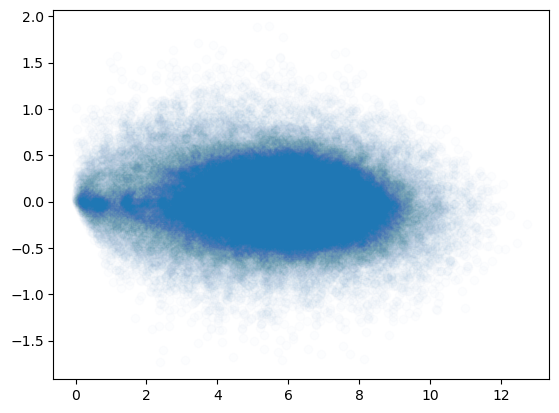

In [38]:
plt.scatter(gm.loc[gm_pass.index.unique().tolist()]["vel"], 
            gm.loc[gm_pass.index.unique().tolist()]["acc"], alpha=0.01)



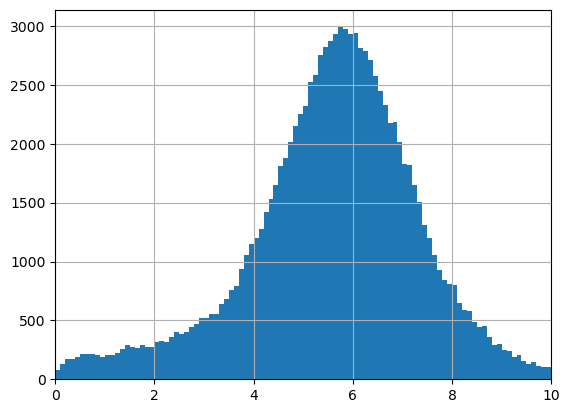

In [39]:

gm.loc[gm_pass.index.unique().tolist()]["vel"].hist(bins=[x/10 for x in range(210)])
#gm["vel"].hist(bins=[x/10 for x in range(210)],alpha=0.1)
plt.xlim([0,10])
plt.show()

In [40]:
gm_trans.head(2)

0         1         2         3     dev_0     dev_1     dev_2  \
52    13.007449  0.739757 -7.871844  9.548887  0.912145  1.760159  1.014303   
2325   8.681101 -3.304201 -4.333718  5.926283  0.276155  2.395326  0.108942   

         dev_3  
52    1.045850  
2325  0.269706

In [41]:
gm_idx.head(2)

vel_mean  acc_mean  dec_mean      idle    cruise  acc_time    vel_max  \
52    6.290832  0.507226 -0.476042  0.403694  0.306069  0.319261  22.961251   
2325  9.950585  0.225491 -0.267855  0.063830  0.191489  0.212766  12.510265   

       acc_max   dec_min  
52    2.749240 -3.239572  
2325  0.412953 -0.688938

## Not sure about weighting the dev
look into more!
But regardless we assign each trip the combined deviance (weighted or not)

In [42]:
#we calculate the combined deviance (weighted) and transfer it back to the og dataframe gm
weight = pca.explained_variance_ratio_.tolist()

gm_trans["dev"] = gm_trans["dev_0"]*weight[0] + gm_trans["dev_1"]*weight[1] + gm_trans["dev_2"]*weight[2] + gm_trans["dev_3"]*weight[3]# + gm_trans["dev_4"] 

In [43]:
gm_idx["dev"] = gm_trans["dev"]
gm["dev"] = np.nan
gm.loc[gm.groupby(level=0).head(1).index, "dev"] = gm_idx["dev"].tolist()
gm["dev"].fillna(method="ffill",inplace=True)

We can see that the overlap between a trip having less than 10% deviance on each principal components (147 trips)
and that lowest total weighted deviance, is pretty significant 

In [44]:
max_dev = gm.groupby(level=0)["dev"].mean().nsmallest(50).max()
gm_good = gm.loc[gm_pass.index.unique().tolist()].copy()
print("out of the fifty trips with the lowest weighted deviance", len(gm_good.loc[gm_good["dev"]<=max_dev].index.unique(level=0)), "of those have less than 10% deviance on any PC")
gm_good = gm_good.loc[gm_good["dev"]<=max_dev].copy()
#gm_good.groupby(level=0)["dev"].mean().nsmallest(8)

out of the fifty trips with the lowest weighted deviance 44 of those have less than 10% deviance on any PC


In [45]:
(gm_good.groupby(level=0)["duration"].mean()/60).mean()

18.68230932954545

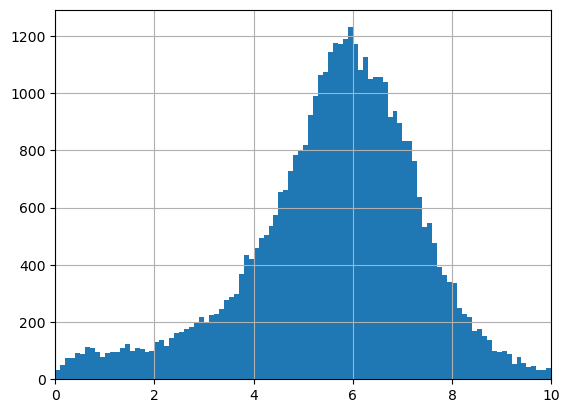

In [46]:
gm_good["vel"].hist(bins=[x/10 for x in range(200)])
plt.xlim([0,10])
plt.show()

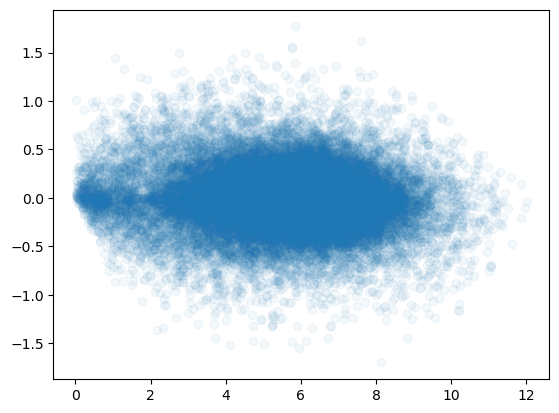

In [47]:
plt.scatter(gm_good["vel"], gm_good["acc"], alpha=0.05)

We can compare drawing a random trip from our good trips (frame)

In [48]:
idl = random.sample(gm_good.index.unique(level=0).tolist(), 1)

test = gm.loc[idl]
test_idx = gm_idx.loc[idl]

print("             new    OG")
print("mean vel:  ", round(test["vel"].mean(),2)," ", round(gm["vel"].mean(),2))
print("mean acc:  ", round(test["pos_acc"].mean(),2)," ", round(gm["pos_acc"].mean(),2))
print("mean dec:  ", round(test["neg_acc"].mean(),2), round(gm["neg_acc"].mean(),2))
print("% idle:    " , round(test_idx["idle"].mean(),2)," ", round(gm_idx["idle"].mean(),2))
print("% cruise:  ", round(test_idx["cruise"].mean(),2), " ", round(gm_idx["cruise"].mean(),2))
print("max vel:   ", round(test_idx["vel_max"].mean(),2)," ", round(gm_idx["vel_max"].mean(),2))
print("max acc:   ", round(test_idx["acc_max"].mean(),2)," ", round(gm_idx["acc_max"].mean(),2))
print("min dec:   ", round(test_idx["dec_min"].mean(),2)," ", round(gm_idx["dec_min"].mean(),2))

             new    OG
mean vel:   5.31   5.43
mean acc:   0.23   0.22
mean dec:   -0.19 -0.21
% idle:     0.05   0.08
% cruise:   0.4   0.35
max vel:    12.01   10.63
max acc:    0.93   1.16
min dec:    -0.93   -1.15


In [49]:
idl = random.sample(gm.index.unique(level=0).tolist(), 1)

test = gm.loc[idl]
test_idx = gm_idx.loc[idl]

print("             new    OG")
print("mean vel:  ", round(test["vel"].mean(),2)," ", round(gm["vel"].mean(),2))
print("mean acc:  ", round(test["pos_acc"].mean(),2)," ", round(gm["pos_acc"].mean(),2))
print("mean dec:  ", round(test["neg_acc"].mean(),2), round(gm["neg_acc"].mean(),2))
print("% idle:    " , round(test_idx["idle"].mean(),2)," ", round(gm_idx["idle"].mean(),2))
print("% cruise:  ", round(test_idx["cruise"].mean(),2), " ", round(gm_idx["cruise"].mean(),2))
print("max vel:   ", round(test_idx["vel_max"].mean(),2)," ", round(gm_idx["vel_max"].mean(),2))
print("max acc:   ", round(test_idx["acc_max"].mean(),2)," ", round(gm_idx["acc_max"].mean(),2))
print("min dec:   ", round(test_idx["dec_min"].mean(),2)," ", round(gm_idx["dec_min"].mean(),2))

             new    OG
mean vel:   7.41   5.43
mean acc:   nan   0.22
mean dec:   -0.19 -0.21
% idle:     0.0   0.08
% cruise:   0.31   0.35
max vel:    8.41   10.63
max acc:    -0.02   1.16
min dec:    -0.34   -1.15


In [50]:
gm["vel"].quantile(0.99)

12.188277344182106

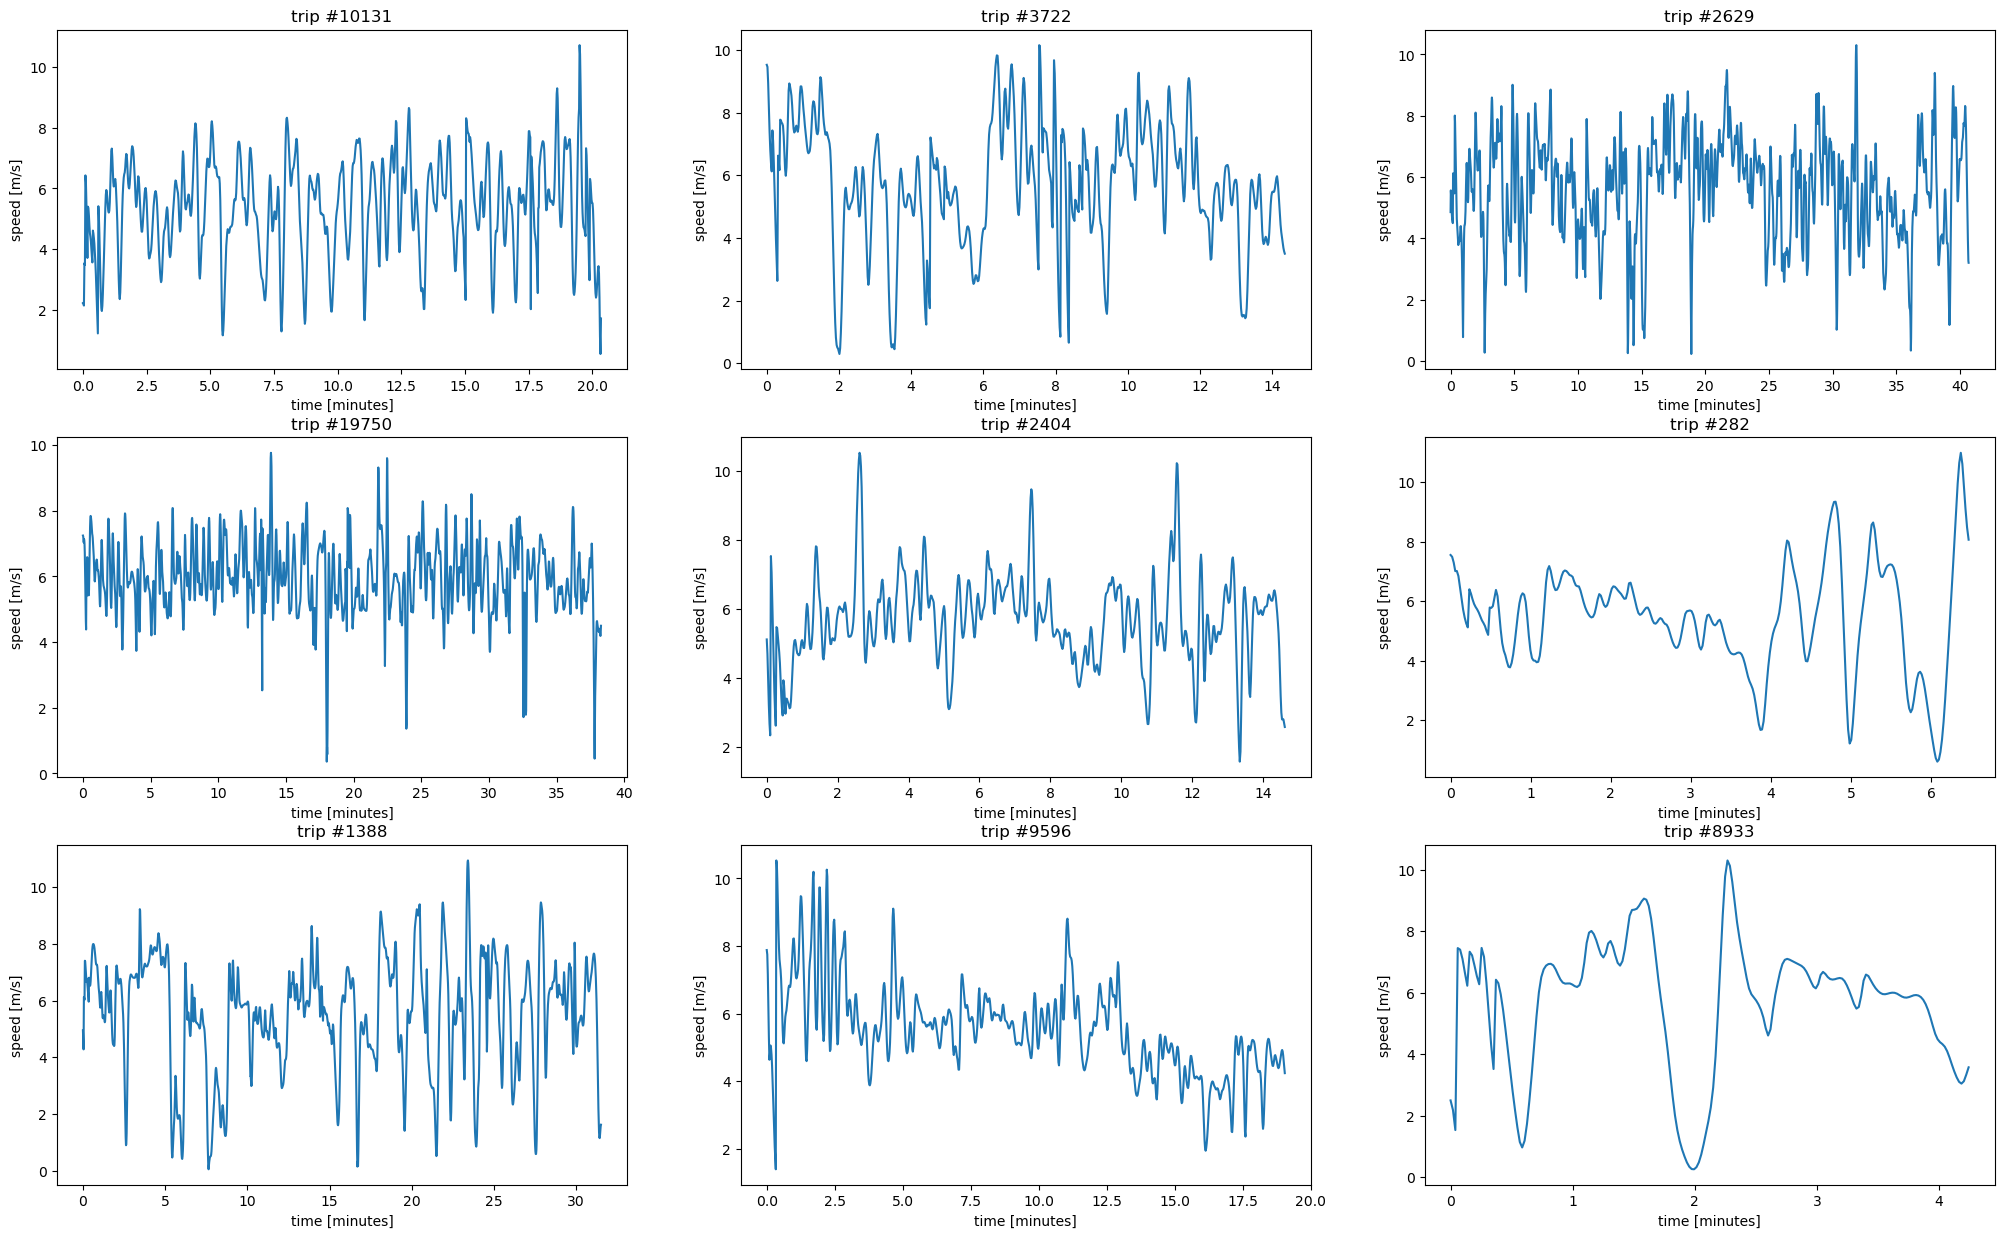

In [72]:
frame = gm_good
idx_long = frame.groupby(level=0)["dev"].mean().nsmallest(9).index.unique(level=0).tolist()


N = 9


fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = idx_long[i]
    times = [x/60 for x in gm.xs(trip)["timesum"].tolist()]
    vels = gm.xs(trip)["vel"].tolist()
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    #plt.xlim([0, 10])
    plt.title("trip #"+str(trip))

plt.show()

In [60]:
five_best = gm_good.loc[gm_good.groupby(level=0)["dev"].mean().nsmallest(10).index]

In [61]:
five_best.groupby(level=0)["duration"].mean()/60

id_origine
282       6.468303
1388     31.501220
2404     14.617192
2629     40.666278
3722     14.343608
8933      4.240549
9596     19.053158
10131    20.342910
19471     2.520879
19750    38.282190
Name: duration, dtype: float64

In [70]:
#gm_1388 = gm.xs(3722).reset_index()[["vel", "acc","timesum"]]

In [71]:
#gm_1388.to_csv("3722_trip.csv")

In [118]:
tc_save.groupby(level=0).head(1)

og_idx  length           purpose  \
trajectory_id t                                                              
52            2013-06-25 16:21:21.000000       0     0.0           Commute   
53            2013-06-25 16:21:20.000000       3     0.0           Commute   
56            2013-06-26 12:46:01.000000       4     0.0  Domicile-travail   
114           2013-06-29 12:44:04.000000      10     0.0             Autre   
115           2013-06-29 15:19:13.000000      11     0.0            Errand   
...                                          ...     ...               ...   
28885         2015-08-30 13:05:28.000000    4875     0.0        Magasinage   
28893         2015-08-30 15:40:30.000000    4878     0.0        Magasinage   
28904         2015-08-30 19:35:18.000000    4879     0.0        Magasinage   
28938         2015-08-31 14:46:36.000000    4880     0.0        Magasinage   
28942         2015-08-31 14:29:50.000000    4871     0.0  Aller au travail   

                                          duration                      dt  \
trajectory_id t                                                              
52            2013-06-25 16:21:21.000000     775.0  0 days 00:00:01.359649   
53            2013-06-25 16:21:20.000000     776.0  0 days 00:00:00.544944   
56            2013-06-26 12:46:01.000000     844.0  0 days 00:00:02.404558   
114           2013-06-29 12:44:04.000000     497.0  0 days 00:00:01.227160   
115           2013-06-29 15:19:13.000000     900.0  0 days 00:00:01.386749   
...                                            ...                     ...   
28885         2015-08-30 13:05:28.000000     336.0  0 days 00:00:01.191489   
28893         2015-08-30 15:40:30.000000    2161.0  0 days 00:00:04.511482   
28904         2015-08-30 19:35:18.000000    1049.0  0 days 00:00:02.227176   
28938         2015-08-31 14:46:36.000000     102.0  0 days 00:00:05.204082   
28942         2015-08-31 14:29:50.000000     423.0  0 days 00:00:02.053398   

                                                            geometry       id  \
trajectory_id t                                                                 
52            2013-06-25 16:21:21.000000  POINT (-73.57748 45.50690)        0   
53            2013-06-25 16:21:20.000000  POINT (-73.57748 45.50690)     1339   
56            2013-06-26 12:46:01.000000  POINT (-73.60502 45.51903)     1693   
114           2013-06-29 12:44:04.000000  POINT (-73.56248 45.51596)     9837   
115           2013-06-29 15:19:13.000000  POINT (-73.59056 45.54466)    10045   
...                                                              ...      ...   
28885         2015-08-30 13:05:28.000000  POINT (-73.59568 45.56549)  4304940   
28893         2015-08-30 15:40:30.000000  POINT (-73.58119 45.52601)  4305545   
28904         2015-08-30 19:35:18.000000  POINT (-73.57111 45.52104)  4305945   
28938         2015-08-31 14:46:36.000000  POINT (-73.54533 45.54429)  4306302   
28942         2015-08-31 14:29:50.000000  POINT (-73.57367 45.51974)  4304037   

                                               vel      time   timesum  acc  
trajectory_id t                                                              
52            2013-06-25 16:21:21.000000  2.361878  1.359649  1.359649  0.0  
53            2013-06-25 16:21:20.000000  4.613513  0.544944  0.544944  0.0  
56            2013-06-26 12:46:01.000000  9.116636  2.404558  2.404558  0.0  
114           2013-06-29 12:44:04.000000  0.380009  1.227160  1.227160  0.0  
115           2013-06-29 15:19:13.000000  6.790095  1.386749  1.386749  0.0  
...                                            ...       ...       ...  ...  
28885         2015-08-30 13:05:28.000000  3.591600  1.191489  1.191489  0.0  
28893         2015-08-30 15:40:30.000000  0.120696  4.511482  4.511482  0.0  
28904         2015-08-30 19:35:18.000000  0.160315  2.227176  2.227176  0.0  
28938         2015-08-31 14:46:36.000000  7.793635  5.204082  5.204082  0.0  
28942         2015-08-

## the vel dist

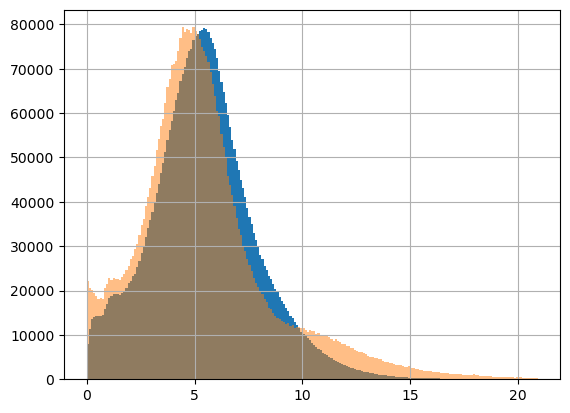

In [131]:
#(gdf["length"]/1.17).hist(bins=[x/10 for x in range(210)])
gm["vel"].hist(bins=[x/10 for x in range(210)])
tc_save["vel"].hist(bins=[x/10 for x in range(210)], alpha=0.5)
#plt.xlim([0,10])
plt.show()

# Elevation

In [733]:
gm.head(2)

trajectory_id  id_origine    length  purpose  \
MT t                                                                          
1  2013-06-25 16:21:40.932534              0          52  9.913699  Commute   
   2013-06-25 16:21:42.105036              0          52  9.776124  Commute   

                               id    duration                     dt  \
MT t                                                                   
1  2013-06-25 16:21:40.932534  16  226.292886 0 days 00:00:01.172502   
   2013-06-25 16:21:42.105036  17  226.292886 0 days 00:00:01.172502   

                                                 geometry       vel  stop  \
MT t                                                                        
1  2013-06-25 16:21:40.932534  POINT (-73.57790 45.50811)  8.334226     0   
   2013-06-25 16:21:42.105036  POINT (-73.57784 45.50819)  8.330169     0   

                               ...  elev_start      acc   acc_in  MT  pos_acc  \
MT t                           ...                                              
1  2013-06-25 16:21:40.932534  ...   52.034226 -0.00346  0.08397   1      NaN   
   2013-06-25 16:21:42.105036  ...   51.658927 -0.09859 -0.00346   1      NaN   

                               neg_acc  cruise  acc_time       dev  idle  
MT t                                                                      
1  2013-06-25 16:21:40.932534 -0.00346       1         0  0.297275     0  
   2013-06-25 16:21:42.105036 -0.09859       1         0  0.297275     0  

[2 rows x 22 columns]

In [734]:
gm["elev_end"] = gm.groupby(level=0)["elev_start"].shift(periods=-1)
gm["elev_end"].fillna(method="ffill",inplace=True)

In [735]:
gm["slope"] = (gm["elev_end"]-gm["elev_start"])/gm["length"]
gm["slope"].fillna(0, inplace=True) #last point is nan

In [736]:
idl = np.abs((gm.groupby(level=0)["elev_start"].min() - gm.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
frame = gm.loc[idl]

In [737]:
#deg_gm = gm.loc[gm["length"]>0].sample(n=10000).copy()
#deg_gm["degree"] = np.arctan(deg_gm["slope"])

In [738]:
tc_save["elev_end"] = tc_save.groupby(level=0)["elev_start"].shift(periods=-1)
tc_save["elev_end"].fillna(method="ffill",inplace=True)
tc_save["slope"] = (tc_save["elev_end"]-tc_save["elev_start"])/tc_save["length"]
tc_save["slope"].fillna(0, inplace=True) #last point is nan

In [739]:
#uncomment the first thrree to plot for un-smoothed data
#uncomment the last three for data through kalmanfilter

idl = np.abs((tc_save.groupby(level=0)["elev_start"].min() - tc_save.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
frame = tc_save.loc[idl]
gm_deg = tc_save.loc[idl].copy()

#idl = np.abs((gm.groupby(level=0)["elev_start"].min() - gm.groupby(level=0)["elev_start"].max())).nlargest(500).index.tolist()
#gm_deg = gm.loc[idl].copy()
#frame = gm.loc[idl]

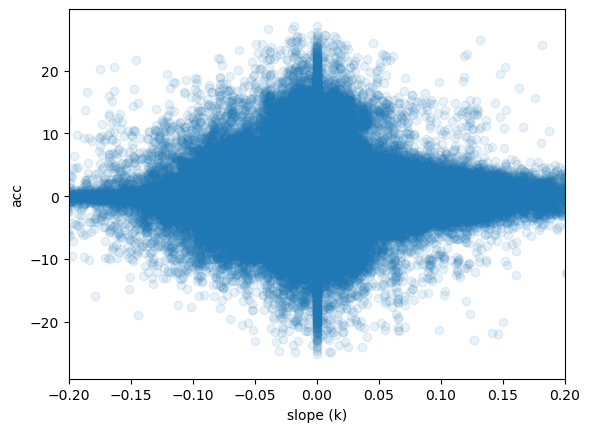

In [740]:
plt.scatter(frame.loc[frame["length"]>0]["slope"], frame.loc[frame["length"]>0]["acc"], alpha=0.1)
plt.xlim([-0.2,0.2])
plt.xlabel("slope (k)")
plt.ylabel("acc")
plt.show()

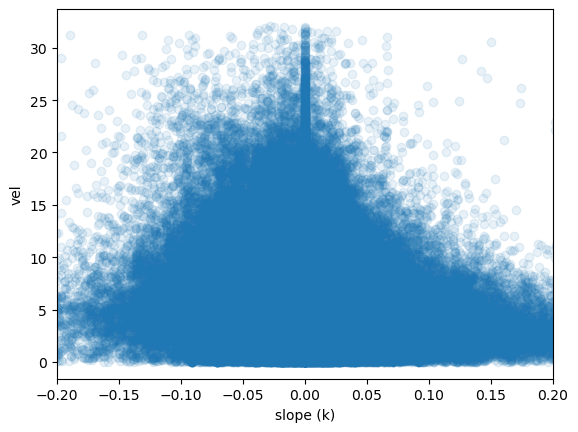

In [741]:
plt.scatter(frame.loc[frame["length"]>0]["slope"], frame.loc[frame["length"]>0]["vel"], alpha=0.1)
plt.xlim([-0.2,0.2])
plt.xlabel("slope (k)")
plt.ylabel("vel")
plt.show()

In [742]:
#Here we simply set the bin-sizes for the average speed
variable = "slope"  
grouped_variable_name = "slope_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(-10,11):
    bin_edges.append(i/(50))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(-10,11):
    bin_labels.append(k)

# This part does the grouping based on the input above
gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

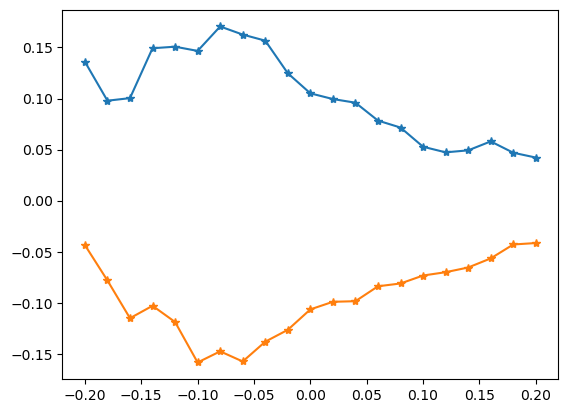

In [743]:
x = [y/50 for y in gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].quantile(0.7).index.tolist()]
y = gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].quantile(0.7).tolist()
plt.plot(x,y, "-*")

x = [y/50 for y in gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].quantile(0.3).index.tolist()]
y = gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].quantile(0.3).tolist()
plt.plot(x,y, "-*")

plt.show()

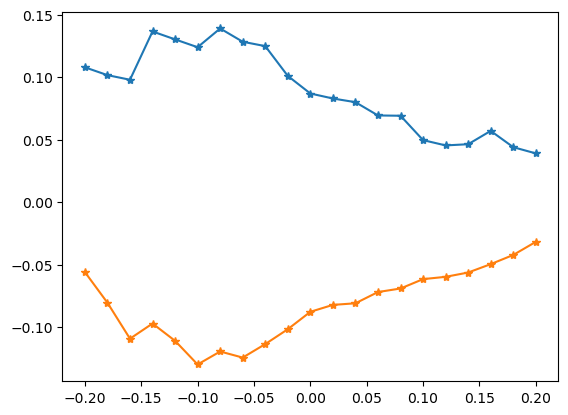

In [744]:
x = [y/50 for y in gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].mean().index.tolist()]
y = gm.loc[gm["acc"]>0].groupby("slope_bin")["acc"].mean().tolist()
plt.plot(x,y, "-*")

x = [y/50 for y in gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].mean().index.tolist()]
y = gm.loc[gm["acc"]<0].groupby("slope_bin")["acc"].mean().tolist()
plt.plot(x,y, "-*")

plt.show()

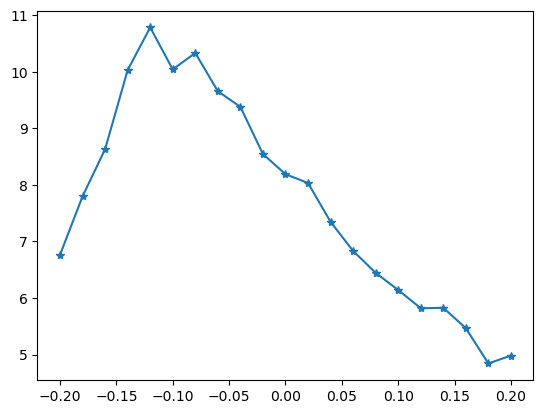

In [745]:
x = [y/50 for y in gm.groupby("slope_bin")["vel"].quantile(0.7).index.tolist()]
y = gm.groupby("slope_bin")["vel"].quantile(0.9).tolist()
plt.plot(x,y, "-*")


plt.show()

# AFTER OPT

In [498]:
import pickle

# Okay
The idea is to compare the results to some other stuff. The things to compare is
* OPT physics
* OPT constant
* OPT data

* Random
* best of five random trips



How to do this? 
* Should we use OG data or smoothed? Should we smooth after the fact? It feels wrong to not use OG data since we are using an acceleration function based on OG data. 
* Should we cut all histograms off over 10 m/s? Because otherwise they are hard to compare to each other. But then how to we compare that to the random trips we choose? Actually, this is not a problem for the 5 random trips choosen. But keep in mind.

## Plan
First issue, the trips have a timestep op 1.51 seconds. We would like to change this so that it is 2 seconds. OR we just scale the histograms so that

# this is the histogram we are working with!!!

OG data 

In [255]:
H_scaled = [4.512743388441156, 4.273652521789638, 4.076151085825884, 4.050617109775722, 3.776513745661481, 3.751560087248823, 3.8283554546118106, 4.079439552438405, 4.4003552059779425, 4.422213836990581, 4.6798748680422175, 4.7874270701929005, 4.483534067353471, 4.657822797817078, 4.727654353530021, 4.802902207192999, 4.942371879406385, 5.279923305221028, 5.383219844696684, 5.770872026549146, 6.177287812014226, 6.458935305416015, 6.8469743656934785, 7.375450294246835, 7.64394392119854, 8.330266247152897, 8.749062142218058, 9.519143647185448, 10.012607078276082, 10.561394124142065, 11.172081718008444, 11.865174416400345, 12.09285236951429, 12.838173655281523, 13.359685772184836, 13.770163781112442, 14.083922183789435, 14.604273665417738, 15.27705524649701, 15.54477511659871, 15.851569707625659, 15.914050573263555, 15.973242972288931, 16.013478328489185, 16.06783474720203, 15.7792234421502, 15.812688425912912, 15.61866889577418, 15.558702739898798, 15.046282265983045, 14.85980686513186, 14.618975045567831, 13.858372062013002, 13.710777942874564, 13.332023964797159, 12.778400938618644, 12.2990585700406, 11.783349629512326, 11.448893231097701, 10.731040313505643, 10.260015831065152, 9.876425872675217, 9.318547183821673, 8.845201430831167, 8.550593510191797, 8.010124350463364, 7.583590886898157, 7.294786142633822, 6.818925679880801, 6.469574462103583, 6.128734569676418, 5.814202410149421, 5.542226877372694, 5.231176623670718, 4.926703303193785, 4.695156565829815, 4.529379160716262, 4.274619717852144, 4.242895687001942, 3.923527547162415, 3.7165475897861002, 3.6716696924858154, 3.510341389259791, 3.390602516721531, 3.1905863709952604, 3.174917794782661, 2.982058899918936]
vel = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6]

# Random

In [256]:
random_route = []
vel_list = [round(x) for x in H_scaled]

for i in range(len(vel_list)):
    v_curr = vel[i]
    for j in range(vel_list[i]):
        random_route.append(v_curr)
random.shuffle(random_route)

rand_df = pd.DataFrame(random_route, columns=['vel'])
rand_df["time"] = [2*x for x in range(len(random_route))]
rand_df["vel_smooth"] = rand_df["vel"].rolling(5).mean()

v_use = ["vel", "vel_smooth"]
acc_name = ["acc", "acc_smooth"]
for i in range(2):
    rand_df[acc_name[i]] = -rand_df[v_use[i]].diff(periods=-1)
    rand_df[acc_name[i]] = rand_df.loc[:, (acc_name[i])]/2

rand_df.dropna(inplace = True)

variable = "vel_smooth"  
grouped_variable_name = "vel_smooth_bin"

rand_df[grouped_variable_name] = pd.cut(
    rand_df[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [257]:
rand_df.head(2)

vel  time  vel_smooth  acc  acc_smooth vel_smooth_bin
4  3.4     8        3.80  0.7        0.27             38
5  4.8    10        4.34 -1.4       -0.37             43

<BarContainer object of 87 artists>

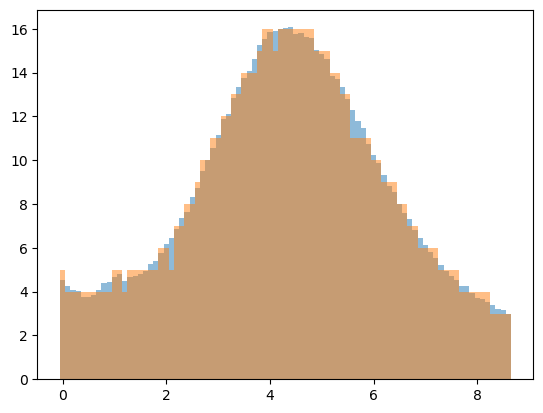

In [258]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data", width=0.1)
plt.bar(vel, rand_df.groupby("vel")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

# random trips

In [259]:
trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()

NameError: name 'GM' is not defined

In [1319]:
N_trip = 3
trips = [1011, 91, 915, 1390, 1192] #random

trips_df_list = []
for i in range(N_trip):
    trip = trips[i]
    trips_df = pd.DataFrame(GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)]["time_sum"].tolist(), columns=['time_sum'])
    cols = ["vel", "acc", "vel_smooth", "acc_smooth", "vel_bin", "vel_OG_bin"]

    for col in cols:
        trips_df[col] = GM.loc[(GM["trip_id"] == trip_ids[trip]) & (GM["count"]>=0) & (GM["time_sum"]<=25)][col].tolist()

    trips_df.rename(columns={'vel_bin': 'vel_smooth_bin'}, inplace=True)
    trips_df.rename(columns={'vel_OG_bin': 'vel_bin'}, inplace=True)
    trips_df_list.append(trips_df)

In [1320]:
trips_df_list[0].head(3)

time_sum       vel       acc  vel_smooth  acc_smooth  vel_smooth_bin  \
0  0.000000  3.618448  0.091599    2.982183    0.252267              30   
1  0.025167  3.756762  2.153695    3.363106    0.549318              34   
2  0.050333  7.008841 -2.242281    4.192577    0.056646              42   

   vel_bin  
0       37  
1       38  
2       71

## Compare the three trips here

we need to scale the histogram so that it matches sum(H_trips) instead of 750

In [1321]:
c = 994/750
H_trips = [x*c for x in H_scaled]

In [1466]:
tr = 2
trips_df = trips_df_list[tr]

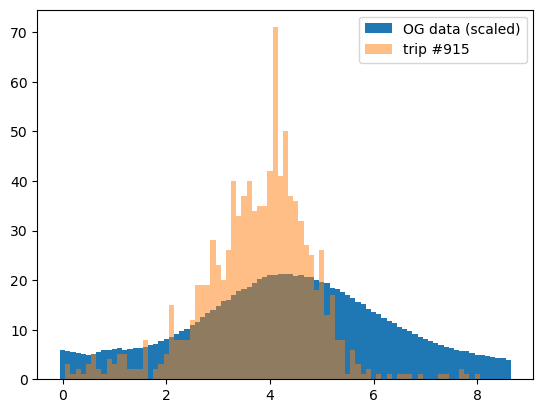

In [1470]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data (scaled)", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="trip #"+str(trips[tr]), width=0.1, alpha = 0.5)
#plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

We can combine their velocities into one histogram (and scale it to 750)

In [1503]:
comb_H = [0 for x in range(100)]

for trips_df in trips_df_list:
    h = trips_df.groupby("vel_bin")["vel_bin"].count().reindex([x for x in range(100)], fill_value=0)
    for i in range(100):
        comb_H[i] += h[i]/N_trip

c = 750/sum(comb_H)
comb_H = [x*c for x in comb_H]
print("scaled:", round(sum(comb_H)), round(sum(H_scaled)))

scaled: 750 750


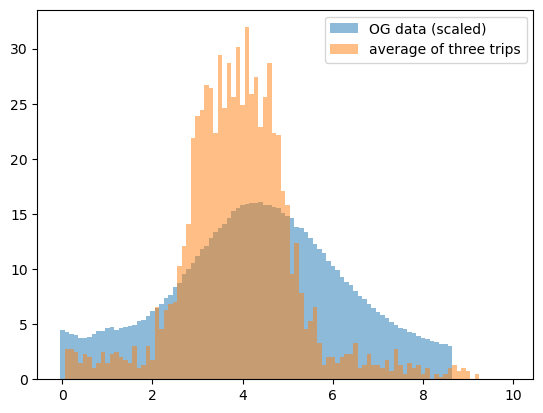

In [1471]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H, label="average of three trips", alpha=0.5, width=0.1)
plt.legend()
plt.show()

# One trip

In [260]:
variable = "vel"  
grouped_variable_name = "vel_bin"

gm_good[grouped_variable_name] = pd.cut(
    gm_good[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [261]:
variable = "vel"  
grouped_variable_name = "vel_bin"

one_trip[grouped_variable_name] = pd.cut(
    one_trip[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [262]:
variable = "vel"  
grouped_variable_name = "vel_bin"

gm[grouped_variable_name] = pd.cut(
    gm[variable],
    bins= vel + [np.inf],
    labels= [x for x in range(len(vel))],
    right=False) 

In [263]:
gm_c = np.sum(gm.groupby("vel_bin")["vel"].count().tolist()[0:-1])
ot_c = np.sum(one_trip.groupby("vel_bin")["vel"].count().tolist())
scale_ot = gm_c/ot_c

In [264]:
gm_c = np.sum(gm.groupby("vel_bin")["vel"].count().tolist()[0:-1])
good_c = np.sum(gm_good.groupby("vel_bin")["vel"].count().tolist())
scale_good = gm_c/good_c

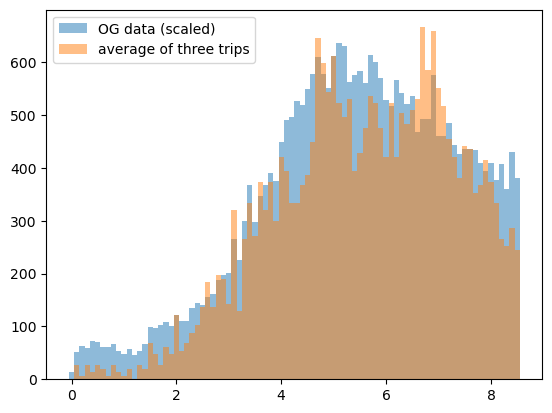

In [266]:
plt.bar(vel[0:-1], gm.groupby("vel_bin")["vel"].count().tolist()[0:-1],alpha=0.5,label="OG data (scaled)", width=0.1)
#plt.bar(vel, (one_trip.groupby("vel_bin")["vel"].count()*scale_ot).tolist(), label="average of three trips", alpha=0.5, width=0.1)
plt.bar(vel[0:-1], (gm_good.groupby("vel_bin")["vel"].count()*scale_good).tolist()[0:-1], label="average of three trips", alpha=0.5, width=0.1)

plt.legend()
plt.show()



# optimized trip

In [267]:
#runs = ["phys_wStops", "phys_noStops", "phys_wStops_OG", "const_cut_87_OG"]
runs = ["OPT_physics", "OPT_constant", "OPT_data"]
#runs = ["phys_wStops_OG", "const_cut_87_OG", "dist_cut_87_OG"]
#runs = ["OPT_physics", "phys_wStops_OG"]
opt_df_list = []

for name in runs:
    with open("pickle/"+name+".pickle", 'rb') as handle: #open
        x_val_dic = pickle.load(handle)

    x_val = x_val_dic[0][1::] #the first elem in list is opt-val - not a velocity
    opt_df = pd.DataFrame(x_val, columns=['vel'])
    opt_df["time"] = [2*x for x in range(len(x_val))]


    opt_df["vel_smooth"] = opt_df["vel"].rolling(5).mean()

    v_use = ["vel", "vel_smooth"]
    acc_name = ["acc", "acc_smooth"]
    for i in range(2):
        opt_df[acc_name[i]] = -opt_df[v_use[i]].diff(periods=-1)
        opt_df[acc_name[i]] = opt_df.loc[:, (acc_name[i])]/2

    opt_df.dropna(inplace = True)

    variable = "vel_smooth"  
    grouped_variable_name = "vel_smooth_bin"

    opt_df[grouped_variable_name] = pd.cut(
        opt_df[variable],
        bins= vel + [np.inf],
        labels= [x for x in range(len(vel))],
        right=False) 
    opt_df_list.append(opt_df)

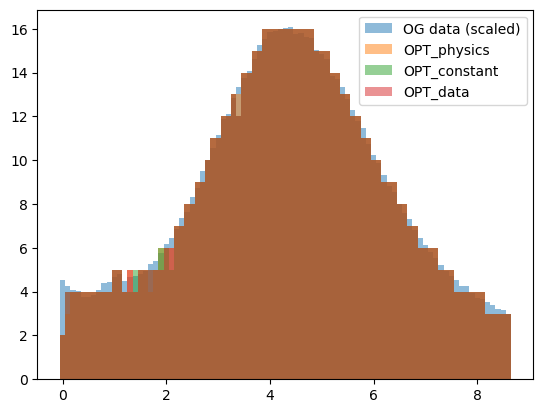

In [268]:
plt.bar(vel, H_scaled,alpha=0.5,label="OG data (scaled)", width=0.1)
for i in range(len(runs)):
    opt_df = opt_df_list[i]
    lab = runs[i]
    plt.bar(vel, opt_df.groupby("vel")["vel"].count().tolist(), label=lab,alpha=0.5,width=0.1)
plt.legend()
plt.show()


# Compare

In [269]:
print("mean velocity:")
print("OG data:", round(gm.loc[gm["vel"]<=8.6]["vel"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel"].mean(),2))
print("random:", round(rand_df["vel"].mean(),2))
print("one trip:", round(one_trip["vel"].mean(),2))
#print("three trips:", round((trips_df_list[0]["vel"].mean() + trips_df_list[1]["vel"].mean() + trips_df_list[2]["vel"].mean())/3,2))


mean velocity:
OG data: 5.46
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.35
one trip: 6.01


In [270]:
one_trip.rename(columns={"acc":"acc"},inplace=True)
gm.rename(columns={"acc":"acc"},inplace=True)

In [273]:
list_name = opt_df_list + [gm.loc[gm["vel"]<=8.6], rand_df, one_trip]
names = runs + ["OG", "RANDOM", "one_trip"]
acc_time = []
dec_time = []
cruise_time = []
N_trip=3

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)
            

In [274]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 46.31 %
OPT_constant 53.83 %
OPT_data 50.2 %
OG 27.36 %
RANDOM 46.19 %
one_trip 28.26 %

time spent decelerating:
OPT_physics 30.47 %
OPT_constant 33.29 %
OPT_data 36.91 %
OG 25.12 %
RANDOM 46.6 %
one_trip 27.34 %

time spent cruising:
OPT_physics 23.22 %
OPT_constant 12.89 %
OPT_data 12.89 %
OG 47.52 %
RANDOM 7.21 %
one_trip 44.4 %


## number of stops
Since I've all but dropped "smoothed" data, the number of stops should now instead be defined from the OG data. So the number of stops *should* be 31.. (we could also check whether the smoothed OPT is close to 9 stops?)

In [1511]:
#state 0 means we are in a "stop-period"
#state 1 means we are in a "drive-period"

max_vel = 2#limit for what is considered "stop"
velocities = opt_df_list[0]["vel"].tolist()
stops = []    #list to save all stop-periods

state = 1     #we start in a drive-period (I know this because I know the data, might have to change if other data is used)
one_stop = [] #list to save all velocities for one stop-period




for i in range(1, len(velocities)): 
    v = velocities[i]                  #current vel
    
    if state == 0 and v < max_vel:    #we are in a stop-period and we stay there
        one_stop.append(v)             #keep adding "stop-period"-velocities, 
        #state = 0                     #stay in state
        
    elif state == 0 and v >= max_vel:   #we are leaving a stop-period
        one_stop.append(v)         #add vel *just after* stop-period
        stops.append(one_stop)     #save this stop
        state = 1                  #change state
            
    elif state == 1 and v < max_vel:   #we are entering a stop-period
        one_stop = [velocities[i-1], v]#add vel *just before* stop-period AND first vel *in* stop-period
        state = 0
    else: #state = 1 v > 1
        state = 1
print(len(stops))

31


##  stops
* All OPTs has (predictably) 31 stops
* random has 82
* trip 1: 13, trip 2: 16, trip 3: 18

# anything else to compare?

* speed vs acceleration?

In [1512]:
opt_df

vel  time  vel_smooth   acc  acc_smooth vel_smooth_bin
4    2.7     8        1.94  0.40        0.35             19
5    3.5    10        2.64  0.45        0.29             26
6    4.4    12        3.22  0.40        0.30             32
7    5.2    14        3.82  0.15        0.22             38
8    5.5    16        4.26 -1.75       -0.07             42
..   ...   ...         ...   ...         ...            ...
744  3.6  1488        3.48  0.40        0.01             34
745  4.4  1490        3.50 -0.25        0.06             35
746  3.9  1492        3.62 -0.15        0.07             36
747  3.6  1494        3.76  0.20        0.07             37
748  4.0  1496        3.90 -2.00       -0.36             39

[745 rows x 6 columns]

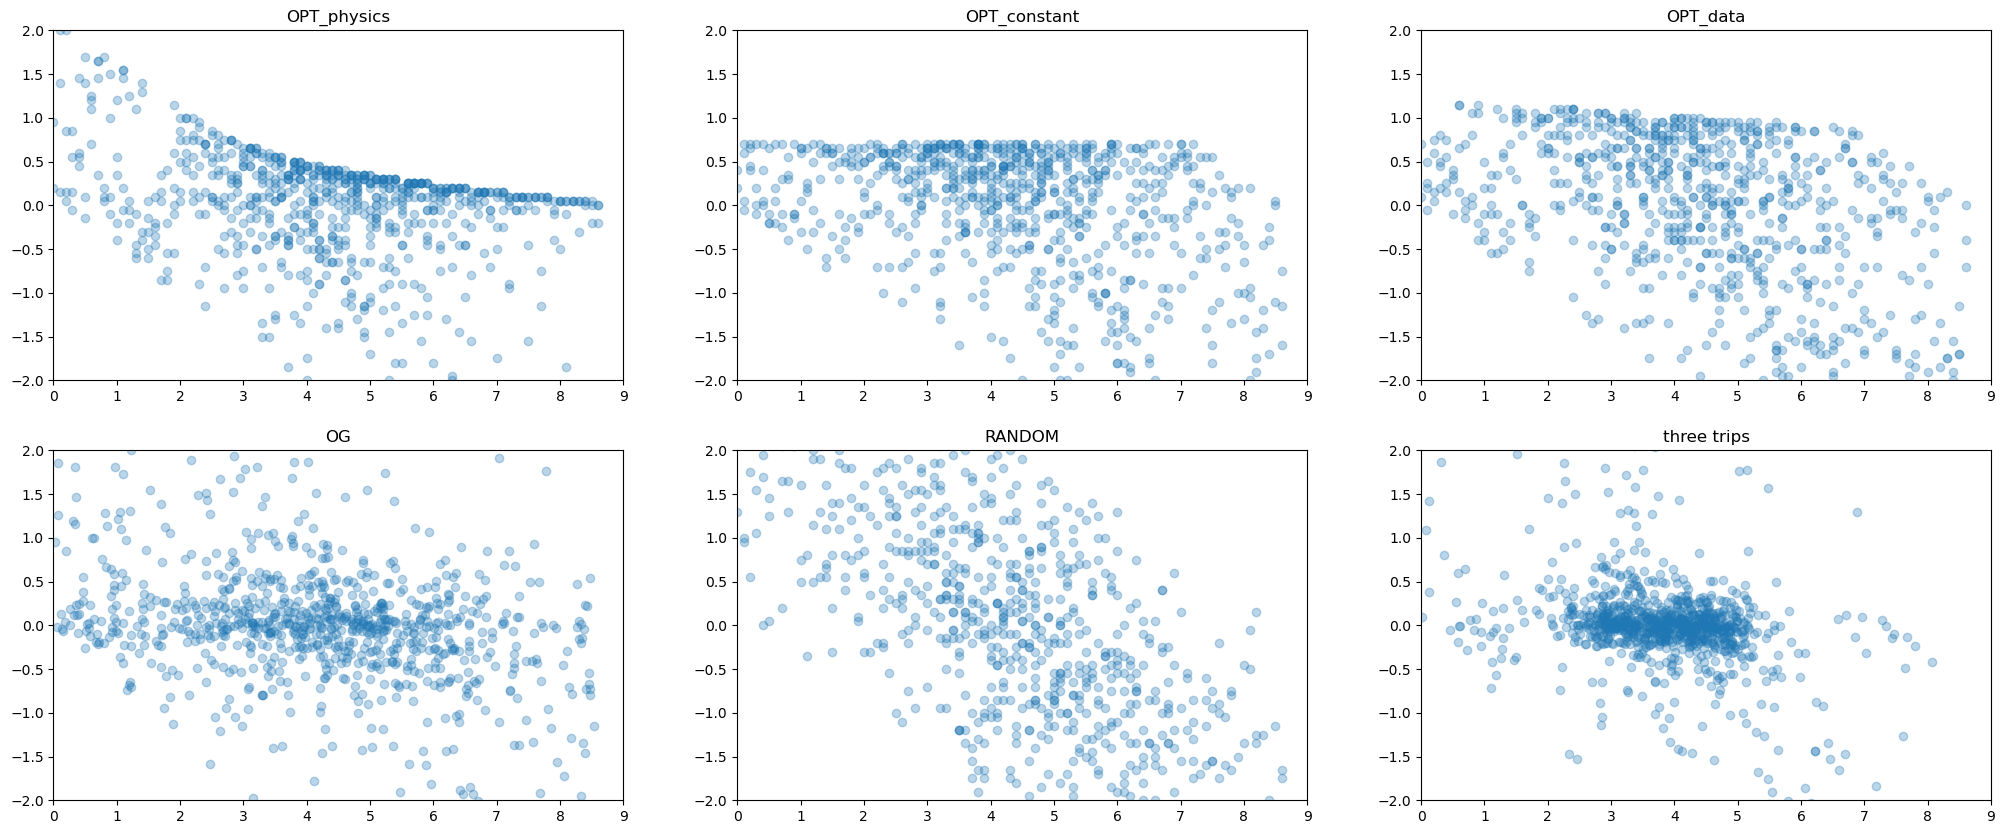

In [1536]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel'], 
           y=frame['acc'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel"],
                y=sub_frame["acc"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])

plt.show()

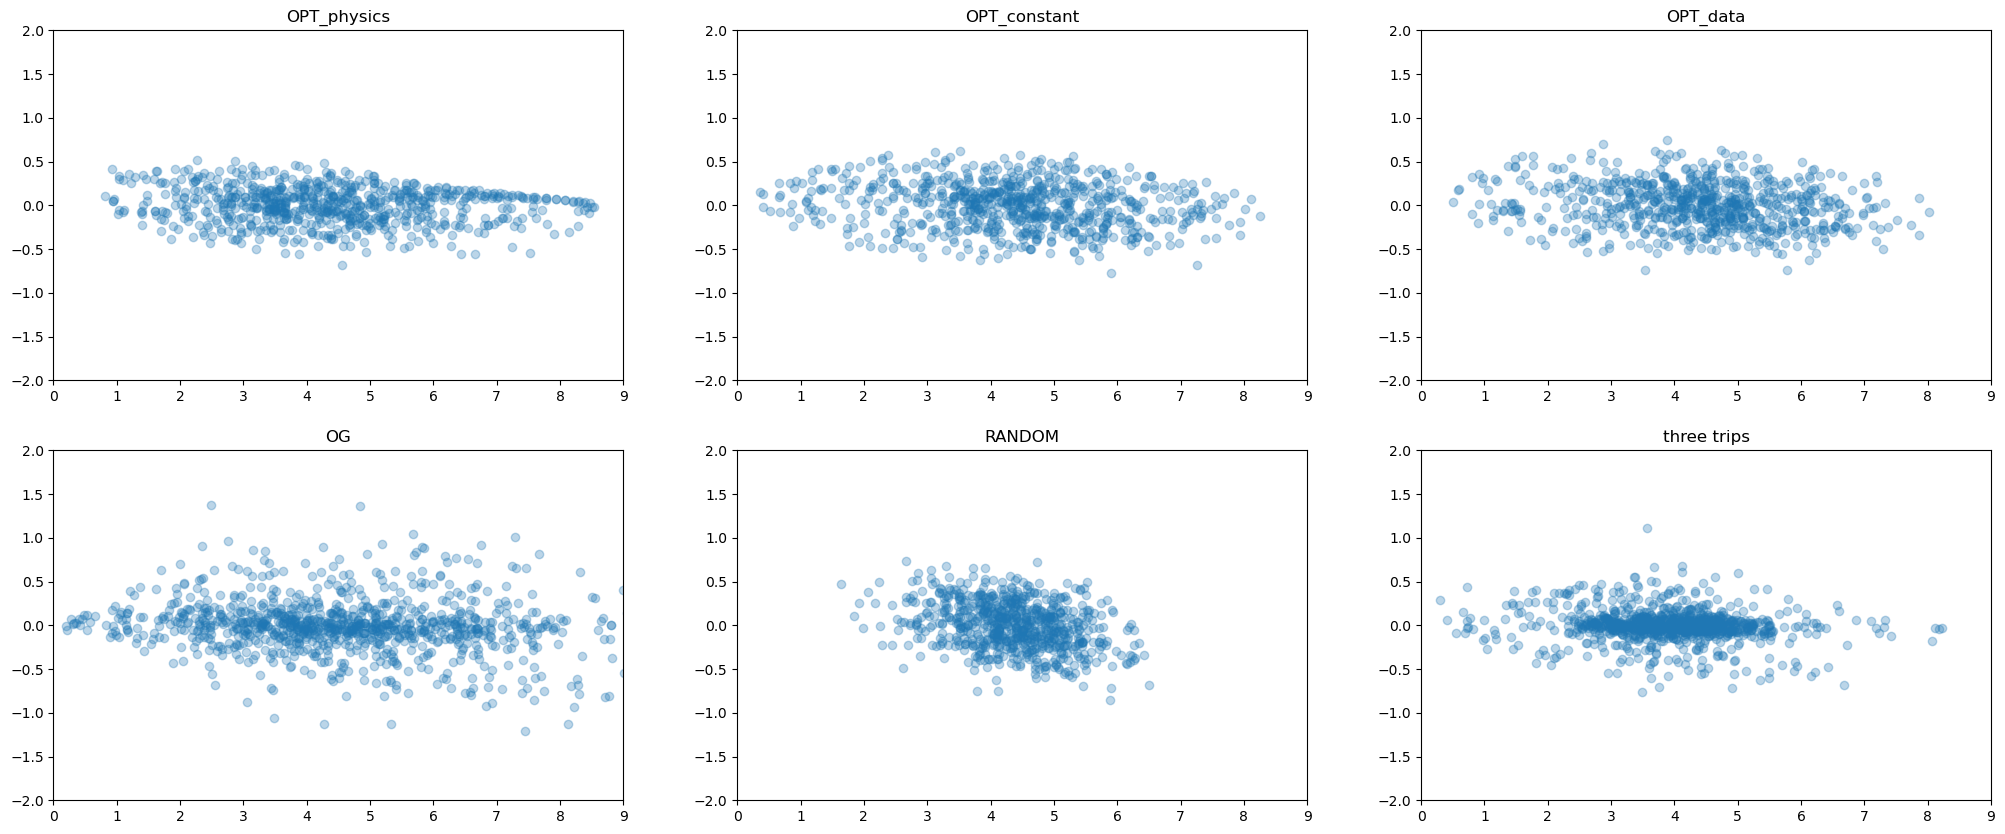

In [1535]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
size = 1000
fig = plt.figure(figsize=(25, 5*round(2)))


for i in range(len(list_name)):
    frame = list_name[i]
    if len(frame) > N_trip:
        if len(frame) > size:
            frame = frame.sample(n=size)
        plt.subplot(2,3,i+1)
        plt.scatter(
           x=frame['vel_smooth'], 
           y=frame['acc_smooth'], alpha=0.3)
        plt.title(names[i])
        plt.ylim([-2,2])
        plt.xlim([0,9])
    else:
        for sub_frame in frame:
            sub_frame = sub_frame.sample(n=333)
            plt.subplot(2,3,i+1)
            plt.scatter(
                x=sub_frame["vel_smooth"],
                y=sub_frame["acc_smooth"], alpha=0.3, color='tab:blue')
            plt.title(names[i])
            plt.ylim([-2,2])
            plt.xlim([0,9])


plt.show()

In [ ]:
frame = gm.sample(10000)

plt.scatter(frame["vel"], frame["acc"], alpha=0.01)
plt.ylim([-2,2])
plt.xlim([0,10])
plt.show()

# SMOOTH (not now)

In [1326]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]




In [1546]:
compare_H = H_scaled + [0 for x in range(len(comb_H)-len(H_scaled))]
comb_H = comb_H
opt_H = opt_df_list[2].groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
rand_H = rand_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().reindex([x for x in range(100)], fill_value=0).tolist()
comb_abs = 0
opt_abs = 0
rand_abs = 0
for i in range(len(comb_H)):
    x = compare_H[i]
    comb_abs += abs(x-comb_H[i])
    opt_abs += abs(x-opt_H[i])
    rand_abs += abs(x-rand_H[i])
print(comb_abs)
print(opt_abs)
print(rand_abs)

In [1549]:
print("mean velocity:")
print("OG data:", round(GM.loc[GM["vel_smooth"]<=8.6]["vel_smooth"].mean(),2))
for i in range(len(runs)):
    print(runs[i], round(opt_df_list[i]["vel_smooth"].mean(),2))
print("random:", round(rand_df["vel_smooth"].mean(),2))
print("three trips:", round((trips_df_list[0]["vel_smooth"].mean() + trips_df_list[1]["vel_smooth"].mean() + trips_df_list[2]["vel_smooth"].mean())/3,2))


mean velocity:
OG data: 4.64
OPT_physics 4.37
OPT_constant 4.37
OPT_data 4.37
random: 4.36
three trips: 3.86


In [1552]:
list_name = opt_df_list + [GM.loc[(GM["count"]>=0) & (GM["vel"]<=8.6)], rand_df, trips_df_list]
names = runs + ["OG", "RANDOM", "three trips"]
acc_time = []
dec_time = []
cruise_time = []

for frame in list_name:
    if len(frame) > N_trip:
        frame_len = len(frame)
        acc_time.append(len(frame.loc[(frame["acc_smooth"] > 0.100001)])/frame_len)
        dec_time.append((len(frame.loc[frame["acc_smooth"] < -0.100001]))/frame_len)
    else:
        acc_sub = 0
        dec_sub = 0
        for sub_frame in frame:
                    frame_len = len(sub_frame)
                    acc_sub += len(sub_frame.loc[(sub_frame["acc_smooth"] > 0.100001)])/frame_len
                    dec_sub +=(len(sub_frame.loc[sub_frame["acc_smooth"] < -0.100001]))/frame_len
        acc_time.append(acc_sub/N_trip)
        dec_time.append(dec_sub/N_trip)

In [1553]:
print("time spent accelerating:")
for i in range(len(list_name)):
    print(names[i], round(acc_time[i]*100,2), "%")

        
print("\ntime spent decelerating:")
for i in range(len(list_name)):
    print(names[i], round(dec_time[i]*100,2), "%")

print("\ntime spent cruising:")
for i in range(len(list_name)):
    print(names[i], round((1-acc_time[i]-dec_time[i])*100,2), "%")

time spent accelerating:
OPT_physics 31.41 %
OPT_constant 36.38 %
OPT_data 33.42 %
OG 27.6 %
RANDOM 34.98 %
three trips 18.48 %

time spent decelerating:
OPT_physics 29.26 %
OPT_constant 35.03 %
OPT_data 34.36 %
OG 28.27 %
RANDOM 36.18 %
three trips 18.21 %

time spent cruising:
OPT_physics 39.33 %
OPT_constant 28.59 %
OPT_data 32.21 %
OG 44.12 %
RANDOM 28.84 %
three trips 63.31 %


In [ ]:
plt.bar([x for x in vel], H_trips,alpha=1,label="OG data", width=0.1)
#trips_df.groupby("vel_bin")["vel_bin"].count().hist(label="OG", width=1)
#trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().hist(label="smooth")
plt.bar([x/10 for x in trips_df.groupby("vel_bin")["vel_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_bin")["vel_bin"].count().tolist()], label="OG", width=0.1, alpha = 0.5)
plt.bar([x/10 for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().index.tolist()], [x for x in trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist()], label="smooth", width=0.1, alpha=0.5)

plt.legend()
plt.show()
#plt.bar([x/10 for x in range(max(trips_df["vel_bin"].tolist()) + 1)], trips_df.groupby("vel_bin")["vel"].count().tolist(), label="random", alpha=0.5, width=0.1)
#plt.bar(vel, trips_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="smooth", alpha=0.5, width=0.1)

In [ ]:
plt.bar([x for x in vel], H_scaled,alpha=1,label="OG data", width=0.1)
plt.bar([x/10 for x in range(100)], comb_H,alpha=0.5,label="all three smooth", width=0.1)
plt.bar(vel, opt_df.groupby("vel_smooth_bin")["vel_smooth_bin"].count().tolist(), label="opt",alpha=0.5,width=0.1)

plt.legend()
plt.show()

# print histogram for optimization

In [500]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [508]:
print(GM.loc[GM["count"] >= 0].groupby("vel_bin").agg("count")["vel_smooth"].tolist())

[2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82,

OG data

In [977]:
#Here we simply set the bin-sizes for the average speed
variable = "vel"  
grouped_variable_name = "vel_OG_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(10))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

In [978]:
print(GM.loc[GM["count"] >= 0].groupby("vel_OG_bin").agg("count")["vel"].tolist())

[23329, 22093, 21072, 20940, 19523, 19394, 19791, 21089, 22748, 22861, 24193, 24749, 23178, 24079, 24440, 24829, 25550, 27295, 27829, 29833, 31934, 33390, 35396, 38128, 39516, 43064, 45229, 49210, 51761, 54598, 57755, 61338, 62515, 66368, 69064, 71186, 72808, 75498, 78976, 80360, 81946, 82269, 82575, 82783, 83064, 81572, 81745, 80742, 80432, 77783, 76819, 75574, 71642, 70879, 68921, 66059, 63581, 60915, 59186, 55475, 53040, 51057, 48173, 45726, 44203, 41409, 39204, 37711, 35251, 33445, 31683, 30057, 28651, 27043, 25469, 24272, 23415, 22098, 21934, 20283, 19213, 18981, 18147, 17528, 16494, 16413, 15416, 14443, 14583, 13872, 13642, 12876, 12715, 12046, 11315, 11560, 11098, 10765, 10631, 10317, 9907, 9715, 9631, 9218, 8668, 8573, 8587, 8261, 8003, 7927, 7415, 7206, 6962, 6597, 6219, 6345, 5881, 5935, 5300, 5307, 5242, 4754, 4645, 4357, 4117, 3980, 3849, 3643, 3423, 3259, 2992, 2903, 2714, 2544, 2449, 2336, 2161, 2007, 1851, 1846, 1714, 1636, 1517, 1418, 1242, 1182, 1122, 1005, 992, 905, 8

# PP plots

In [ ]:
color1=mcp.gen_color(cmap="viridis",n=4)

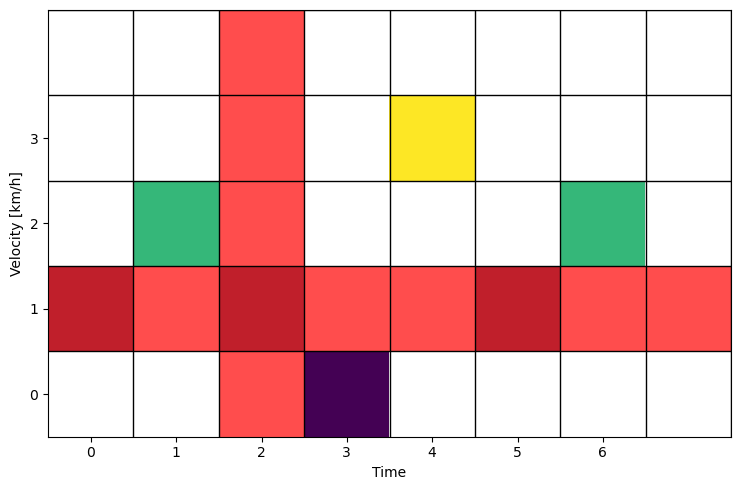

In [975]:
N = 8 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data
data2 = np.ones((M,N))*np.nan

def trip_1(order_list):
    data[0][order_list[0]] = 0 #[y][x]
    data[1][order_list[1]] = 1 #[y][x]
    data[1][order_list[2]] = 1 #[y][x]
    data[1][order_list[3]] = 1 #[y][x]
    data[2][order_list[4]] = 2 #[y][x]
    data[2][order_list[5]] = 2 #[y][x]
    data[3][order_list[6]] = 3 #[y][x]
    sss = 3

    
def const1():
    for i in range(5):
        data2[i][2] = 4
    for i in range(8):
        data2[1][i] = 4
#order_list = [0,1,2,3,4,5,6]
#random.shuffle(order_list)

trip_1(order_list)

a = const1()



# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[0:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)


my_cmap2 = colors.ListedColormap(mcp.gen_color(cmap="hsv",n=1))
# set the 'bad' values (nan) to be white and transparent
my_cmap2.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
plt.xlabel("Time")
plt.ylabel("Velocity [km/h]")

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
ax.imshow(data2, interpolation='none', cmap=my_cmap2, zorder=0, origin='lower', alpha = 0.7);
# turn off the axis labels
#ax.axis('off')

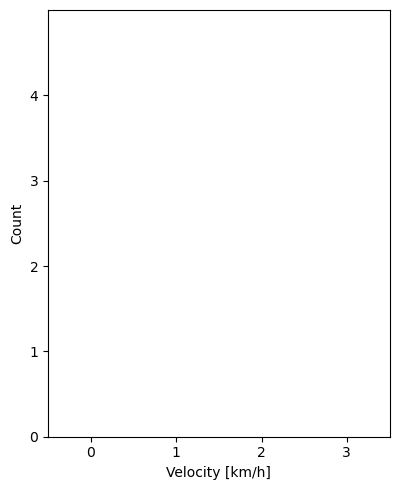

In [817]:
N = 4 #x-ax
M = 5 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data


# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(5,5))
# make color map
my_cmap = colors.ListedColormap(mcp.gen_color(cmap="viridis",n=4)[3:4])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
#for x in range(N + 1):
#    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
#    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N, dtype=np.int64))
plt.yticks(np.arange(0, M, dtype=np.int64))


def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-0.5, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


#data[0][0]=0
#highlight_cell(0,0, color="black", linewidth=1)

#data[0][1]=1
#highlight_cell(1,0, color="black", linewidth=1)

#data[1][1]=1
#highlight_cell(1,1, color="black", linewidth=1)

#data[2][1]=1
#highlight_cell(1,2, color="black", linewidth=1)

#data[0][2]=2
#highlight_cell(2,0, color="black", linewidth=1)

#data[1][2]=2
#highlight_cell(2,1, color="black", linewidth=1)

#data[0][3]=3
#highlight_cell(3,0, color="black", linewidth=1)

ax.imshow(data, interpolation='none', cmap=my_cmap,extent=[-0.5,N-0.5,0,M], zorder=0, origin='lower')
plt.xlabel("Velocity [km/h]")
plt.ylabel("Count")

plt.show()
# turn off the axis labels
#ax.axis('off')

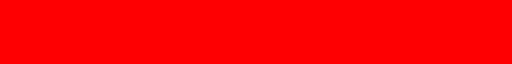

In [676]:
order_list = [0,1,2,3,4,5,6]



None


In [700]:
#Here we simply set the bin-sizes for the average speed
variable = "vel_smooth"  
grouped_variable_name = "plt_vel_bin"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/(1))

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(k)

# This part does the grouping based on the input above
GM[grouped_variable_name] = pd.cut(
    GM[variable],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

H_tilf = GM.loc[GM["count"] >= 0].groupby("plt_vel_bin").agg("count")["vel_smooth"].tolist()

In [726]:
#H_tilf = [2149, 6224, 9633, 12088, 13415, 14307, 15337, 16386, 17707, 19375, 21132, 21745, 22161, 22247, 22408, 23176, 24059, 25243, 26197, 27766, 28993, 30777, 32613, 34957, 36928, 39642, 42006, 44817, 47718, 51213, 54232, 57785, 59514, 62659, 65328, 68640, 70717, 73579, 75932, 77241, 80358, 81265, 82114, 83863, 83796, 84531, 85071, 85456, 85464, 85222, 84738, 82974, 81362, 80259, 78360, 76227, 74562, 72387, 69313, 66875, 64236, 62247, 59279, 56424, 54279, 52163, 49665, 46739, 44796, 43031, 40726, 38623, 36444, 35107, 32939, 31423, 29808, 28078, 26760, 25337, 23835, 22442, 21219, 20133, 19173, 18229, 17391, 16308, 15103, 14669, 13822, 12932, 12056, 11450, 10843, 10043, 9477, 8830, 8288, 7954, 7327, 6944, 6433, 5955, 5753, 5249, 4876, 4530, 4292, 3964, 3632, 3424, 3205, 2925, 2699, 2415, 2218, 2058, 1904, 1911, 1694, 1579, 1397, 1237, 1113, 1073, 1006, 921, 860, 799, 736, 662, 620, 569, 527, 516, 416, 383, 367, 320, 292, 294, 266, 199, 202, 175, 163, 142, 142, 122, 108, 105, 94, 82, 99, 94, 82, 62, 52, 57, 36, 50, 37, 29, 27, 33, 28, 22, 28, 19, 24, 28, 14, 24, 20, 16, 22, 16, 16, 20, 14, 34, 24, 22, 19, 23, 38, 33, 30, 40, 45, 59, 73, 68, 74, 55, 140, 131, 85, 3]
H_scaled = [round(x/sum(H_tilf)*25) for x in H_tilf][0:10]



In [727]:
print(H_scaled)

[1, 1, 2, 4, 5, 4, 3, 2, 1, 1]


In [711]:
from mycolorpy import colorlist as mcp

In [728]:
color1=mcp.gen_color(cmap="viridis",n=len(H_scaled))
print(color1)

['#440154', '#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b', '#fde725']


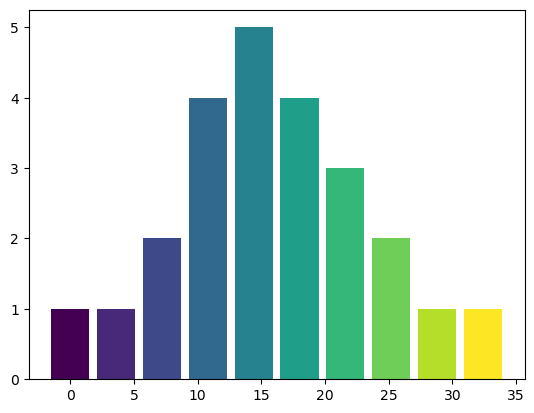

In [729]:
vel_km = [round(x/1*60*60/1000,2) for x in range(len(H_scaled))]
plt.bar(vel_km,H_scaled, color=color1, width=3)
plt.show()

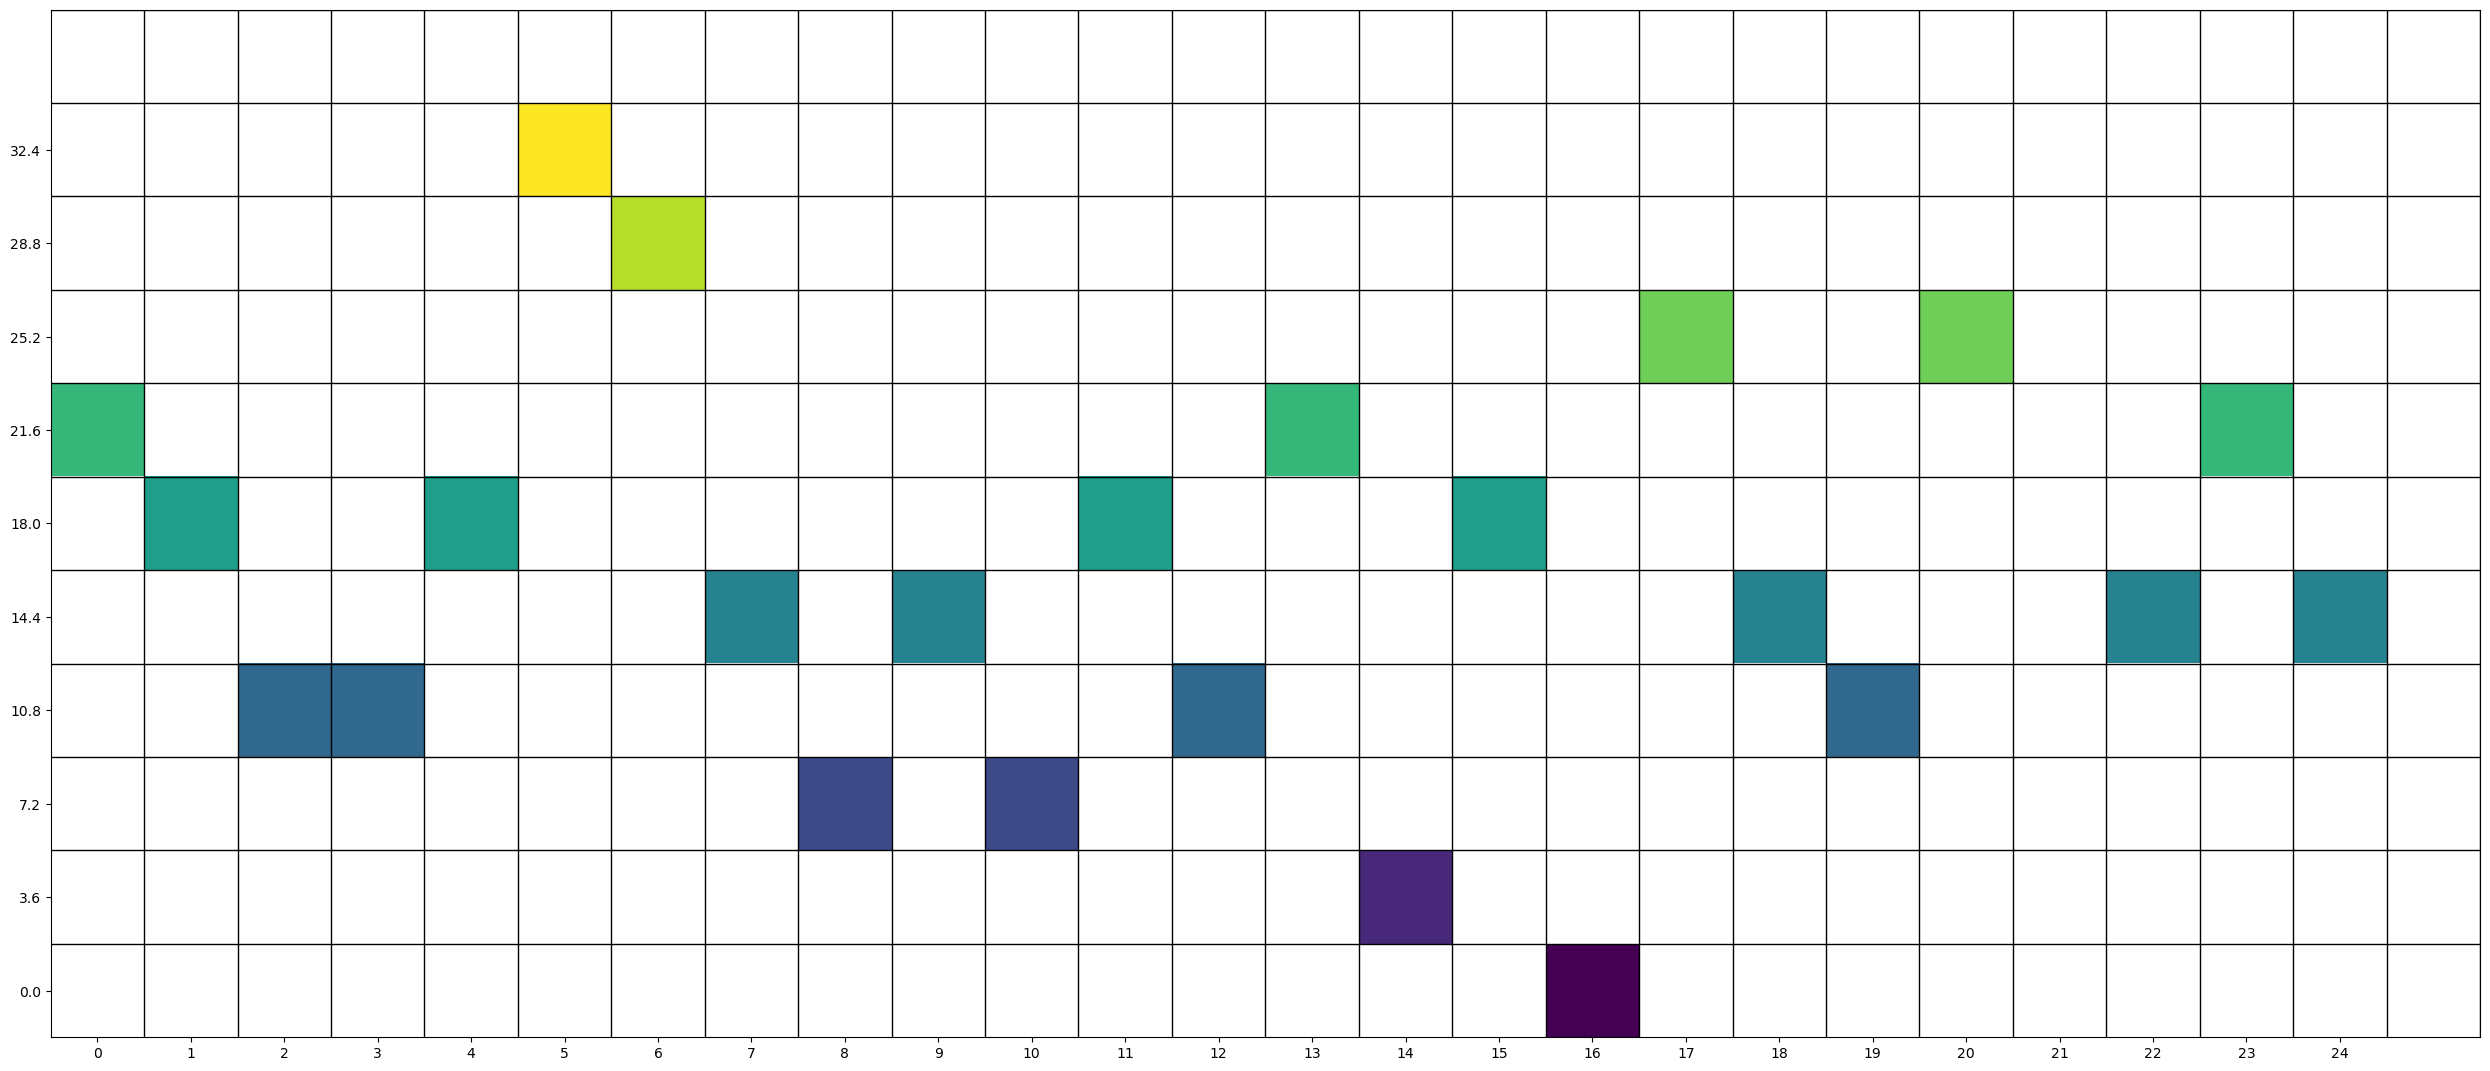

In [750]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower');
# turn off the axis labels
#ax.axis('off')

In [ ]:
N = 26 #x-ax
M = 11 #y-ax
# make an empty data set
data = np.ones((M, N)) * np.nan
# fill in some fake data



def trip_1(order_list):
    idx = 0
    for h in range(len(H_scaled)):
        for i in range(H_scaled[h]):
            data[h][order_list[idx]] = h
            idx += 1


order_list = [x for x in range(25)]
random.shuffle(order_list)

trip_1(order_list)

# make a figure + axes
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(25,25))
# make color map
my_cmap = colors.ListedColormap(color1)
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for x in range(N + 1):
    ax.axhline(x+0.5, lw=1, color='k', zorder=5)
    ax.axvline(x+0.5, lw=1, color='k', zorder=5)
# draw the boxes

plt.xticks(np.arange(0, N-1, dtype=np.int64))
plt.yticks(np.arange(0, M-1, dtype=np.int64))
ax.set_yticklabels(vel_km)

ax.imshow(data, interpolation='none', cmap=my_cmap, zorder=0, origin='lower')
plt.show()
# turn off the axis labels
#ax.axis('off')

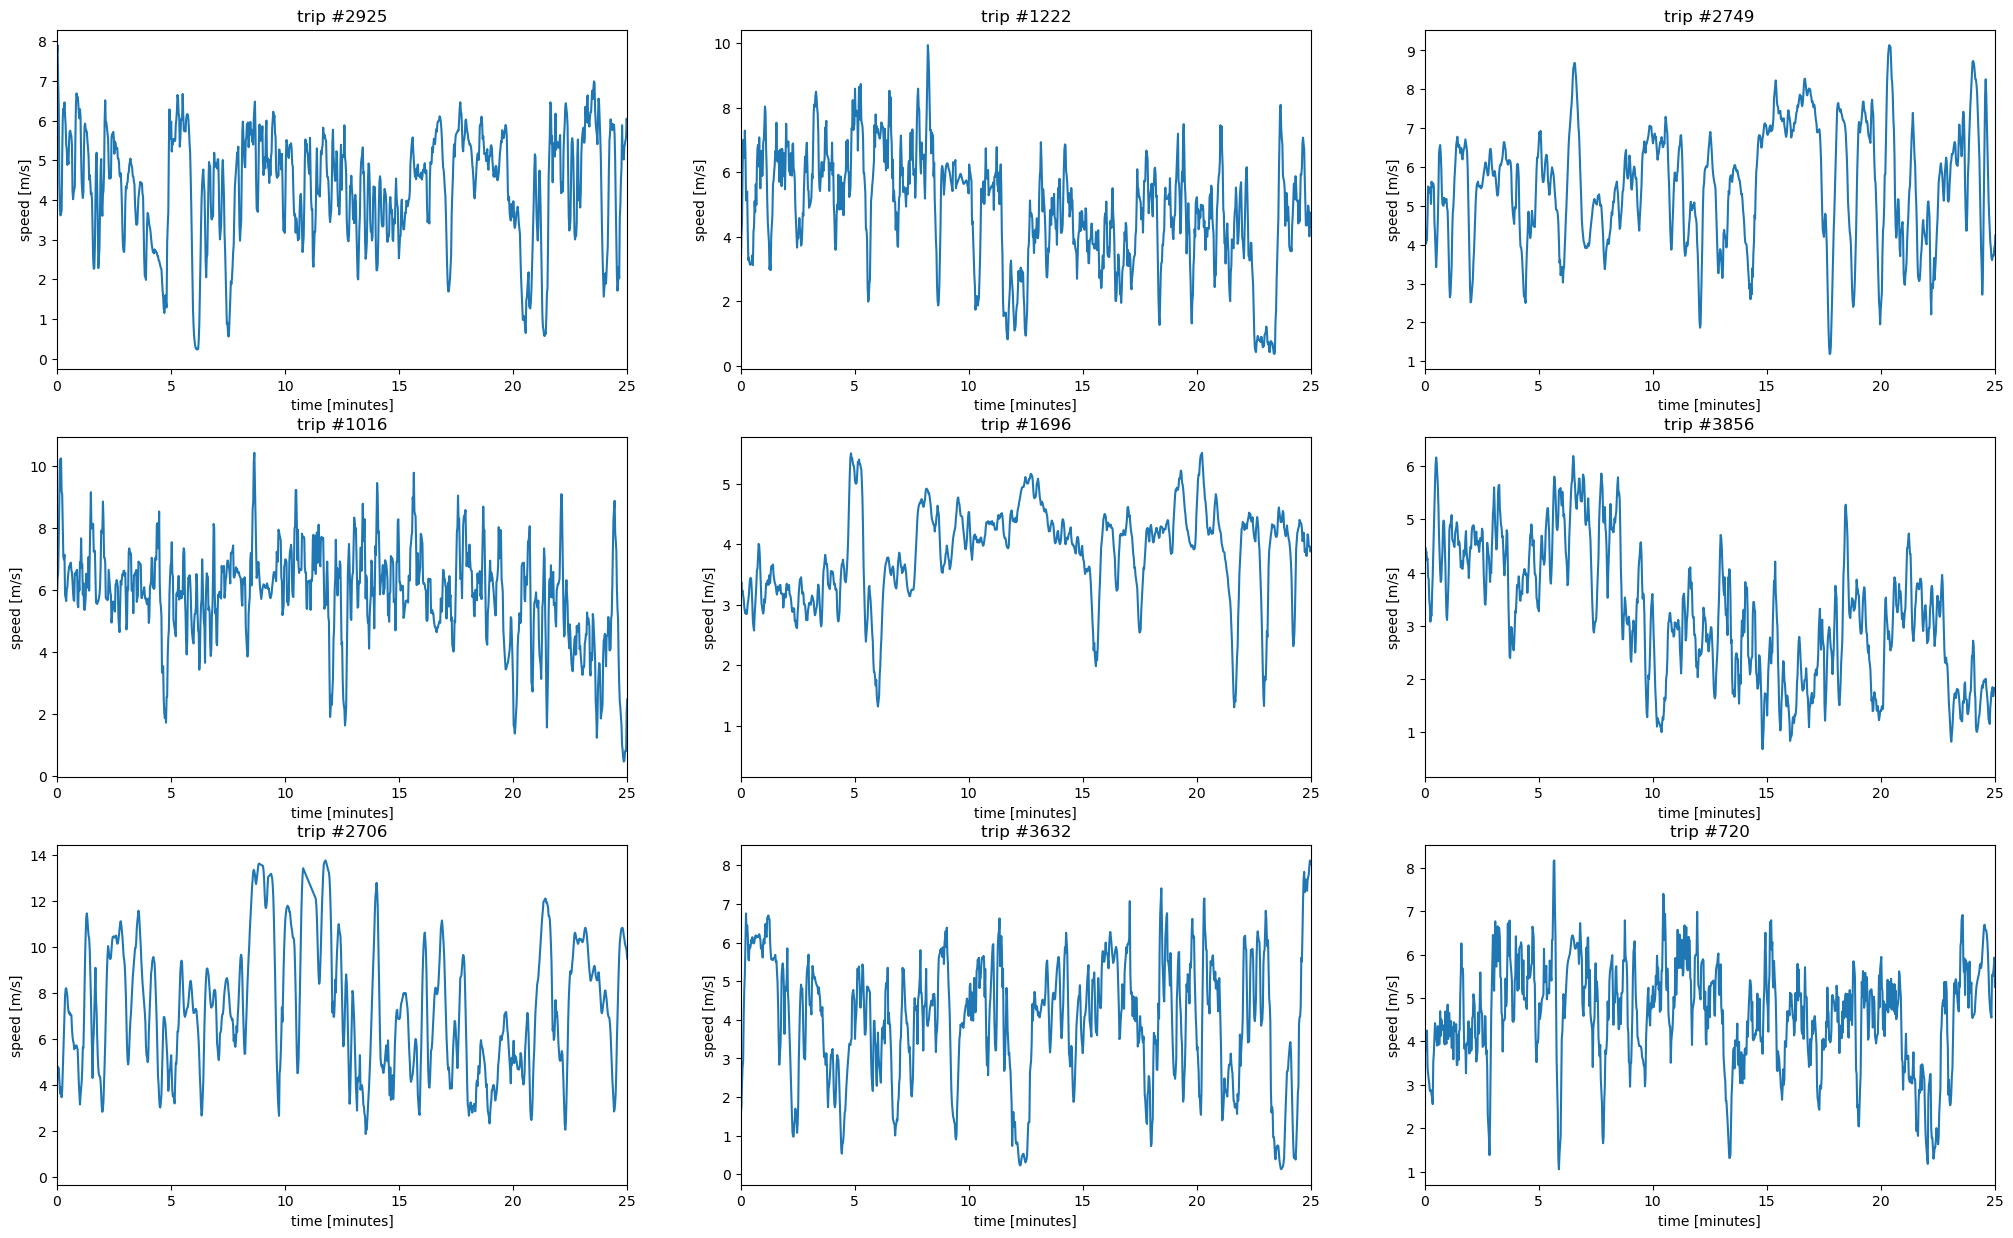

In [1042]:
N = 9

trip_ids = GM.loc[GM["total_time"] >= 25].trip_id.unique().tolist()
trips = [random.randint(0,len(trip_ids)) for x in range(N)]

fig = plt.figure(figsize=(25, 5*round(N/3)))

for i in range(N):
    trip = trip_ids[trips[i]]
    times = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["time_sum"].tolist()
    vels = GM.loc[(GM["trip_id"] == trip) & (GM["count"]>=0)]["vel_smooth"]
    
    plt.subplot(round(N/3),3,i+1)
    plt.xlabel("time [minutes]")
    plt.ylabel("speed [m/s]")
    plt.plot(times, vels, "-")
    #plt.plot([1,2,3], [1,2,3], "-")
    plt.xlim([0, 25])
    plt.title("trip #"+str(trip))

plt.show()

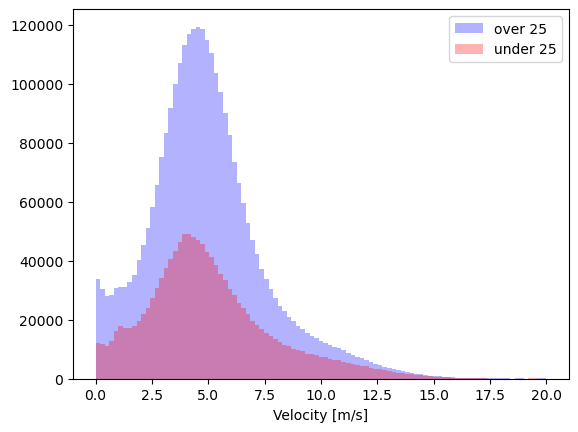

In [1183]:
bins = np.linspace(0, 20, 100) 
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]>=25)]["vel"], label='over 25', bins=bins, alpha=0.3, color='blue')
plt.hist(GM.loc[(GM["count"]>=0) & (GM["total_time"]<=25)]["vel"], label='under 25', bins=bins, alpha=0.3, color='red')

plt.xlabel("Velocity [m/s]")
plt.legend()
 
plt.show()

# discarded: 
cruising band

In [ ]:
V = opt_df["vel_smooth"].tolist()
cale = []
idx_cale = []

for i in range(len(V)):
    v_list = []
    idx_li = []
    v = V[i]
    for j in range(i,len(V)):
        u = V[j]
        if u < v*1.07 and u > v*0.93:
            v_list.append(u)
            idx_li.append(j)
        else:
            if len(v_list) >= 5:
                cale.append(v_list)
                idx_cale.append(idx_li)
                #for el in idx_li:
                #    if el != idx_cale:
                #        idx_cale.append(el)
            break
            
idx_uni = []
col_idx = [0 for x in range(len(opt_df))]


for i in range(len(cale)):
    for el in idx_cale[i]:
        if el not in idx_uni:
            idx_uni.append(el)
            col_idx[el] = 1

In [620]:
print("hallo world")

hallo world


In [623]:
number_list = []
nr_list = []
n_list = [x for x in range(10)]

for number in range(10):
    number_list.append(number)
    nr_list += [number]
    
    
print(number_list)
print(nr_list)
print(n_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
#Here we find the elevationdata in the point closest to the point we have
#this could perhaps be done better if we instead use interpolation
#maybe something to look into
#we also save "dist" which denotes the distance between the gps-point and the elevation data used
#i.e. dist is a measurment of how sure we can be of the assigned elevation

def ckdnearest(gdA, gdB):
    
    nA = np.array(list(gdA.geometry.apply(lambda x: (Point(x.coords[0]).x, Point(x.coords[0]).y))))
    nB = gdB[["lat","long"]]
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)

    gdB_nearest = gdB.iloc[idx]["elevation"]#.drop(columns="geometry").reset_index(drop=True)
    el_li = gdB.iloc[idx]["elevation"].tolist()
    return el_li, dist

elevation_list, dist_list = ckdnearest(gdf, df_el)
gdf["elevation"] = elevation_list
gdf["dist"] = dist_list

In [513]:
#df = pd.read_json(r"reseaucyclable201511.json")

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

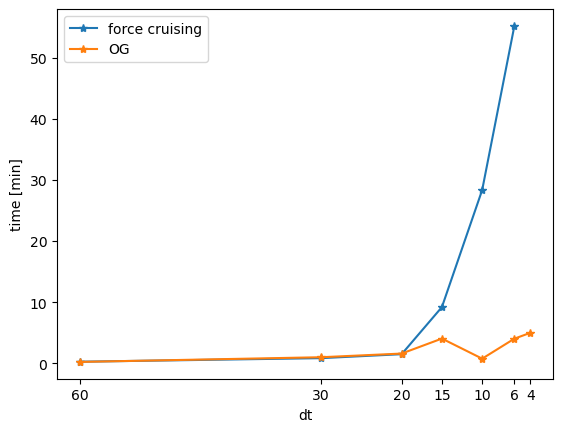

In [806]:
#500 sek dt 10
#1699 for 8 dt
#dt 6 3310
#old dt4 300
#old dt2 3000

x = [6,10,15,20,30,60]
y = [3310,1700,552,90,51,16]
y=[i/60 for i in y]
plt.plot(x,y, "*-",label="force cruising")
x = [4,6,10,15,20,30,60]
y = [300,242,46,243,96,60,14]
y=[i/60 for i in y]
plt.plot(x,y,"*-",label="OG")
plt.gca().invert_xaxis()
plt.xlabel("dt")
plt.ylabel("time [min]")
plt.xticks(x)
plt.legend()
plt.show()

In [807]:
a = [1,2,3]
a[-1]

3

In [73]:
df = pd.read_json(r"trip5000 2.json")

In [76]:
df["features"][0]

{'geometry': {'type': 'LineString',
  'coordinates': [[-73.577476909289, 45.5069002299392],
   [-73.5775104302952, 45.5069169426211],
   [-73.57757, 45.5070110000019],
   [-73.577742, 45.5070480000019],
   [-73.577925, 45.5071840000019],
   [-73.578096, 45.5072940000019],
   [-73.578265, 45.5074030000019],
   [-73.578356, 45.5074450000019],
   [-73.578427, 45.5074790000019],
   [-73.578469, 45.5075160000019],
   [-73.578453, 45.5075900000019],
   [-73.578381, 45.5076690000019],
   [-73.578334, 45.5077190000019],
   [-73.578276, 45.5077730000019],
   [-73.578209, 45.5078370000019],
   [-73.578143, 45.5078980000019],
   [-73.578078, 45.5079580000019],
   [-73.577946, 45.5080820000019],
   [-73.57783, 45.5082160000019],
   [-73.577768, 45.5082780000019],
   [-73.577643, 45.5084030000019],
   [-73.577517, 45.5085180000019],
   [-73.577423, 45.5086190000019],
   [-73.577382, 45.5086640000019],
   [-73.577347, 45.5087100000019],
   [-73.577319, 45.5087460000019],
   [-73.577287, 45.508800000

In [86]:
x = 0.5
e = 3#round(np.e,8)

for i in range(3):
    x = x*(2-e*x)
    print(round(x,8))
    

0.25
0.3125
0.33203125


In [87]:
2/3

0.6666666666666666